In [83]:
j = 22
pos_index_j = np.array(pos_index)[pos_label == j]
neg_index_j = np.array(neg_index)[neg_label == j]
if pca_inhibitor_modes[j] != 0:
    abc = np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[:pca_inhibitor_modes[j]].tolist()
    print(np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[:pca_inhibitor_modes[j]].tolist())
if pca_activator_modes[j] != 0:
    abd = np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[-pca_activator_modes[j]:].tolist()
    print(np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[-pca_activator_modes[j]:].tolist())

[3, 1, 2, 4, 13, 0, 9]


In [88]:
target_columns[22]

'CD194'

In [87]:
[x for i,x in enumerate(cell_columns) if i in abc or i in abd]

['ENSG00000121410_A1BG',
 'ENSG00000268895_A1BG-AS1',
 'ENSG00000175899_A2M',
 'ENSG00000245105_A2M-AS1',
 'ENSG00000128274_A4GALT',
 'ENSG00000094914_AAAS',
 'ENSG00000115977_AAK1',
 'ENSG00000205002_AARD']

In [90]:
j = 23
pos_index_j = np.array(pos_index)[pos_label == j]
neg_index_j = np.array(neg_index)[neg_label == j]
if pca_inhibitor_modes[j] != 0:
    abc = np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[:pca_inhibitor_modes[j]].tolist()
    print(np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[:pca_inhibitor_modes[j]].tolist())
if pca_activator_modes[j] != 0:
    abd = np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[-pca_activator_modes[j]:].tolist()
    print(np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[-pca_activator_modes[j]:].tolist())
print([x for i,x in enumerate(cell_columns) if i in abc or i in abd])
print(target_columns[j])

[1, 3, 13, 0]
['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1', 'ENSG00000245105_A2M-AS1', 'ENSG00000128274_A4GALT', 'ENSG00000094914_AAAS', 'ENSG00000205002_AARD']
CD4


In [116]:
to_drop

array([-1, -1, -1, ..., -1, -1, -1])

In [1]:
!pip install tables
!pip install pytorch_lightning
!pip install keras_tuner
import statistics
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch
import torch.nn as nn
from torchmetrics import PearsonCorrCoef, MeanSquaredError
!pip install colorama
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
import scprep

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import TruncatedSVD

!pip install tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.utils import plot_model
import keras_tuner

%cd /home/jovyan/kaggle/working

%cd robust-pca
import r_pca
%cd ..

def delete_columns_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def correlation_score_cols(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    abc = []
    for i in range(y_true.shape[1]):
        temp = np.corrcoef(y_true[:,i], y_pred[:,i])[1, 0]
        abc.append(temp)
        corrsum += temp
    print(corrsum / y_true.shape[1])
    return abc

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def negative_pearson_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    vx = y_pred - torch.mean(y_pred,1,keepdim=True)
    vy = y_true - torch.mean(y_true,1,keepdim=True)

    cost = torch.mean(torch.sum(vx * vy,1) / (torch.sqrt(torch.sum(vx ** 2,1)) * torch.sqrt(torch.sum(vy ** 2,1))))

    return - cost

def my_model(n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# Cross-validation
VERBOSE = 2 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr

        # We validate the model
        y_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_va, y_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)

        return model

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
    
DATA_DIR = "../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))    
    
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
    cell_columns = data['columns']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)    
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',').astype(int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')
cell_columns = [i for i in cell_columns if i not in constant_cols]
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
y_train -= y_train.mean(axis=1).reshape(-1, 1)
y_train /= y_train.std(axis=1).reshape(-1, 1)
y_train_0 = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
y_train_0 -= y_train_0.mean(axis=0).reshape(1, -1)
y_train_0 /= y_train_0.std(axis=0).reshape(1, -1)
!pip install git+https://github.com/BasisResearch/millipede.git
from millipede import NormalLikelihoodVariableSelector
X_train_pca = np.genfromtxt('./pca256/updated_X_train_cite_pca.csv',delimiter = ',')
# X_train_mod = np.hstack([X_train,X_train_pca])   
# X_train_mod -= X_train_mod.mean(axis=1).reshape(-1, 1)
# X_train_mod /= X_train_mod.std(axis=1).reshape(-1, 1)

  Using cached pytorch_lightning-1.8.0.post1-py3-none-any.whl (796 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached lightning_lite-1.8.0.post1-py3-none-any.whl (136 kB)
  Using cached torchmetrics-0.10.2-py3-none-any.whl (529 kB)
  Using cached lightning_utilities-0.3.0-py3-none-any.whl (15 kB)
  Using cached fire-0.4.0-py2.py3-none-any.whl
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.0
    Uninstalling tensorboard-2.9.0:
      Successfully uninstalled tensorboard-2.9.0
  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
  Using cached tensorf

2022-11-07 16:19:10.187325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 16:19:10.349939: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-07 16:19:10.388370: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 16:19:10.991189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

/home/jovyan/kaggle/working
/home/jovyan/kaggle/working/robust-pca
/home/jovyan/kaggle/working
Constant cols: 1194
important columns  84
  Cloning https://github.com/BasisResearch/millipede.git to /tmp/pip-req-build-xglkjuua
  Running command git clone --filter=blob:none --quiet https://github.com/BasisResearch/millipede.git /tmp/pip-req-build-xglkjuua
  Resolved https://github.com/BasisResearch/millipede.git to commit ecafe4194e216846600ff4f87dc02f65ce4428e2
  Preparing metadata (setup.py) ... done
  Using cached polyagamma-1.3.2-cp39-cp39-manylinux_2_12_x86_64.manylinux_2_5_x86_64.manylinux1_x86_64.manylinux2010_x86_64.whl (523 kB)
  Created wheel for millipede: filename=millipede-0.1.0-py3-none-any.whl size=33845 sha256=82106d24f84a8385e717016c9d4ee795c851379e50ff05e49ce16a342a5d85a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-209xamf9/wheels/0a/6b/57/40b20d03468593c7819cb14105caeb501b22dc304ff2f9193c
Successfully built millipede


In [54]:
(np.argmax(y_train_0[cond_pos],axis=1).ravel())

array([ 15, 113, 118, ...,  84,  35,  34])

In [2]:
y_train_0 = np.array(y_train_0)
cond_pos = ((y_train_0 > 2).sum(axis=1) == 1).ravel()
cond_neg = ((y_train_0 < -2).sum(axis=1) == 1).ravel()
excl_pos = np.logical_and(cond_pos, np.logical_not(cond_neg))
excl_neg = np.logical_and(cond_neg, np.logical_not(cond_pos))
pos_index = [num for (num,i) in enumerate(excl_pos) if i == True]
neg_index = [num for (num,i) in enumerate(excl_neg) if i == True]
pos_label = (np.argmax(y_train_0[excl_pos],axis=1).ravel())
neg_label = (np.argmax(y_train_0[excl_neg],axis=1).ravel())

(array([161.,  41.,  12.,   2.,   7.,  15., 176.,  45.,   3.,  49., 159.,
        213., 116.,  51.,  44.,  73.,  17.,  61.,  95., 355.,  24.,   0.,
        246.,  75.,  34., 136., 175., 138.,  13.,  13.,  19., 145., 118.,
        163., 265.,  74.,  15.,  12.,  10., 208.,  41.,  56.,  52.,  40.,
         87.,  38.,  49.,  39.,  88.,  66.,   8.,  52.,  45., 304.,   9.,
          9.,  30.,  10.,  94., 133., 193.,   0.,   8.,  20.,  58.,  43.,
         31.,  44.,   1.,  48.,   6.,  14., 134.,  36.,  57.,   5.,  83.,
        114., 163.,  82., 177.,  68.,   4.,  40., 222., 201.,  13.,  72.,
          3., 138.,   7.,  25.,   4.,  15.,  10., 108.,  30.,   0.,  54.,
         23.,   3., 305., 129.,  41., 270.,  70.,   6., 149., 118.,  21.,
          5.,  14.,   4., 174.,  92., 217.,  57., 110., 194.,   4.,  44.,
         59., 129., 310.,  26.,  33.,  95.,  55.,  46.,  37.,  58.,  73.,
         25.,  18.,  66.,  11.,  17.,  25.,   4.,  12.]),
 array([  0.        ,   0.99285714,   1.98571429,   2.

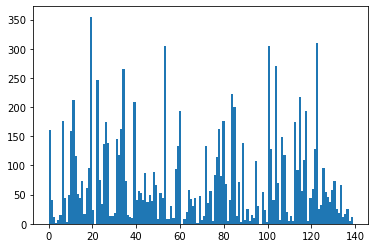

In [58]:
plt.hist(pos_label,bins=140)

(array([178.,  54.,  13.,  18.,   9.,  23., 145.,  55.,   6.,  71., 118.,
        194., 127.,  56.,  56., 114.,  31.,  71., 117., 247.,  56.,   3.,
        190., 103.,  56., 121., 147.,  81.,  17.,  14.,  30., 125., 126.,
        164., 193.,  64.,  36.,  15.,  22., 125.,  42.,  77.,  45.,  94.,
         76.,  38.,  94.,  53.,  73.,  60.,  12.,  53., 166., 190.,  33.,
         22.,  52.,  21., 101., 112., 161.,   7.,  17.,  25., 133.,  54.,
         75.,  52.,   5.,  97.,   9.,  14., 118.,  56.,  60.,  14.,  82.,
        178., 137., 117., 162., 111.,  16.,  44., 197., 172.,  21.,  65.,
         40., 328.,  22.,  30.,  12.,  16.,  48., 254.,  54.,   2.,  41.,
         43.,   8., 158., 160.,  54., 224.,  66.,  12., 169.,  99.,  92.,
         18.,  37.,  29., 391.,  87., 265., 147.,  89., 177.,  12.,  55.,
         71., 131., 207.,  36.,  55.,  90., 131.,  51.,  40.,  49.,  75.,
         37.,  23.,  84.,  25.,  42.,  66.,  10.,  41.]),
 array([  0.        ,   0.99285714,   1.98571429,   2.

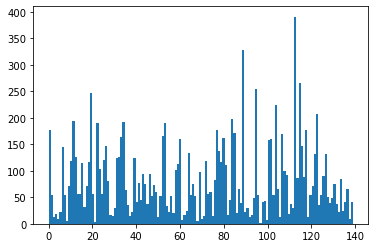

In [59]:
plt.hist(neg_label,bins=140)

In [41]:
len(pos_index)

10308

In [42]:
len(neg_index)

11507

In [43]:
len(set(pos_index+neg_index))

21815

In [65]:
pos_label

array([ 15,  77, 101, ...,  79,  78,  84])

In [67]:
pos_label == 0

array([False, False, False, ..., False, False, False])

In [5]:
import statistics
statistics.mode([1,2,3,3,])

3

In [10]:
X_train -= X_train.mean(axis=0).reshape(1, -1)
X_train /= X_train.std(axis=0).reshape(-1, 1)

In [3]:
n = 140
activator_modes = {}
inhibitor_modes = {}
with open('activ_inhib.txt', 'a') as the_file:
    for j in range(n):
        pos_index_j = np.array(pos_index)[pos_label == j]
        neg_index_j = np.array(neg_index)[neg_label == j]
        if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
            continue
    #    ax[j,0].hist(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0),bins=100)
    #    ax[j,0].axis(ymax=50)
        activators = []
        inhibitors = []
        for k in range(20):
            ind_rand_pos = np.random.randint(low=0, high=len(pos_index), size=len(pos_index_j))
            ind_rand_neg = np.random.randint(low=0, high=len(neg_index), size=len(neg_index_j))
    #    ax[j,1].hist(X_train[ind_rand_pos].mean(axis=0) - X_train[ind_rand_neg].mean(axis=0),bins=100)
    #    ax[j,1].axis(ymax=50)
            pos_cutoff = np.max(X_train[ind_rand_pos].mean(axis=0) - X_train[ind_rand_neg].mean(axis=0))
            neg_cutoff = np.min(X_train[ind_rand_pos].mean(axis=0) - X_train[ind_rand_neg].mean(axis=0))
            activators.append(len([i for i, x in enumerate(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0) > pos_cutoff) if x]))
            inhibitors.append(len([i for i, x in enumerate(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0) < neg_cutoff) if x]))
        activator_modes[j] = statistics.mode(activators)
        inhibitor_modes[j] = statistics.mode(inhibitors)
        print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators')
        print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors')
        the_file.write(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators\n')
        the_file.write(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors\n')

i = 0, 9 (3-42) activators
i = 0, 13 (3-40) inhibitors
i = 6, 1 (1-10) activators
i = 6, 2 (0-8) inhibitors
i = 10, 1 (1-7) activators
i = 10, 4 (0-19) inhibitors
i = 11, 29 (11-31) activators
i = 11, 55 (26-209) inhibitors
i = 12, 4 (4-7) activators
i = 12, 1 (1-48) inhibitors
i = 13, 15 (1-27) activators
i = 13, 12 (6-28) inhibitors
i = 15, 5 (3-67) activators
i = 15, 32 (7-70) inhibitors
i = 17, 1 (0-13) activators
i = 17, 0 (0-15) inhibitors
i = 18, 6 (6-21) activators
i = 18, 3 (2-6) inhibitors
i = 19, 20 (12-49) activators
i = 19, 75 (27-183) inhibitors
i = 22, 4 (4-18) activators
i = 22, 7 (7-115) inhibitors
i = 23, 3 (3-34) activators
i = 23, 1 (1-14) inhibitors
i = 25, 4 (0-10) activators
i = 25, 3 (1-32) inhibitors
i = 26, 6 (1-20) activators
i = 26, 5 (1-9) inhibitors
i = 27, 3 (0-23) activators
i = 27, 1 (1-11) inhibitors
i = 31, 3 (0-20) activators
i = 31, 2 (0-12) inhibitors
i = 32, 5 (3-12) activators
i = 32, 3 (1-25) inhibitors
i = 33, 2 (1-7) activators
i = 33, 3 (1-27

In [123]:
total_inhibitors = []
total_activators = []
for j in range(140):
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) == 0) or (len(neg_index_j) == 0):
        continue
    total_inhibitors+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[:inhibitor_modes[j]].tolist()
    if activator_modes[j] == 0:
        continue
    else:
        total_activators+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[-activator_modes[j]:].tolist()

In [124]:
len(total_inhibitors)

1233

In [125]:
len(set(total_inhibitors))

717

In [126]:
len(total_activators)

766

In [127]:
len(set(total_inhibitors))

717

In [128]:
len(set(total_inhibitors+total_activators))

1029

In [129]:
pd.Series(total_inhibitors+total_activators).value_counts()

16266    75
19920    45
7965     43
3963     27
11477    22
         ..
11999     1
8115      1
16322     1
11041     1
5575      1
Length: 1029, dtype: int64

In [130]:
pd.Series(total_inhibitors+total_activators).value_counts().sum()

1999

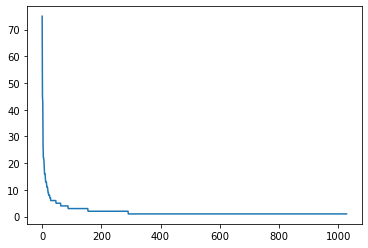

In [131]:
plt.plot(pd.Series(total_inhibitors+total_activators).value_counts().values)

In [3]:
abc = np.array(y_train.mean(axis=0))[0]

NameError: name 'y_train' is not defined

(array([ 6., 13., 16., 18., 10., 10.,  9.,  4.,  6.,  3.,  1.,  1.,  0.,
         0.,  0.,  1.,  3.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  4.,  0.,  2.,  0.,  0.,  0.,  3.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.5392869 , -0.51016766, -0.48104843, -0.45192918, -0.42280993,
        -0.39369068, -0.36457145, -0.3354522 , -0.30633295, -0.2772137 ,
        -0.24809445, -0.21897522, -0.18985598, -0.16073672, -0.1

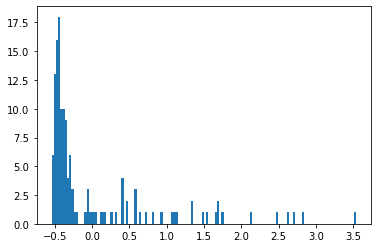

In [53]:
plt.hist(abc,bins=140)

In [57]:
imp_prot = [i for i,x in enumerate(abc>-0.2) if x]

In [58]:
len(imp_prot)

43

In [5]:
X_train -= X_train.mean(axis=0).reshape(1, -1)
X_train /= X_train.std(axis=0).reshape(1, -1)

In [101]:
# standardizing X_train and comparing to thresh
#n = 140
thresh = 1.0
activator_modes = {}
inhibitor_modes = {}
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
        print(f'Passing i = {j}')
        continue
#    ax[j,0].hist(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0),bins=100)
#    ax[j,0].axis(ymax=50)
    activators = []
    inhibitors = []
    activators.append(len([i for i, x in enumerate(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0) > thresh) if x]))
    inhibitors.append(len([i for i, x in enumerate(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0) < -thresh) if x]))
    activator_modes[j] = statistics.mode(activators)
    inhibitor_modes[j] = statistics.mode(inhibitors)
    print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators')
    print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors')

Passing i = 3
Passing i = 4
Passing i = 5
i = 6, 4 (4-4) activators
i = 6, 5 (5-5) inhibitors
Passing i = 14
Passing i = 16
i = 17, 115 (115-115) activators
i = 17, 64 (64-64) inhibitors
i = 18, 45 (45-45) activators
i = 18, 23 (23-23) inhibitors
Passing i = 21
Passing i = 24
Passing i = 37
Passing i = 43
i = 48, 35 (35-35) activators
i = 48, 76 (76-76) inhibitors
Passing i = 54
Passing i = 55
Passing i = 57
Passing i = 68
Passing i = 73
Passing i = 75
i = 77, 28 (28-28) activators
i = 77, 53 (53-53) inhibitors
i = 80, 4 (4-4) activators
i = 80, 8 (8-8) inhibitors
Passing i = 88
i = 89, 7 (7-7) activators
i = 89, 72 (72-72) inhibitors
Passing i = 94
Passing i = 97
Passing i = 99
Passing i = 100
i = 102, 4 (4-4) activators
i = 102, 4 (4-4) inhibitors
i = 104, 1 (1-1) activators
i = 104, 2 (2-2) inhibitors
Passing i = 106
i = 108, 21 (21-21) activators
i = 108, 25 (25-25) inhibitors
Passing i = 109
Passing i = 110
Passing i = 111
i = 113, 7 (7-7) activators
i = 113, 20 (20-20) inhibitors

In [102]:
total_inhibitors = []
total_activators = []
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
        continue
    total_inhibitors+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[:inhibitor_modes[j]].tolist()
    if activator_modes[j] == 0:
        continue
    else:
        total_activators+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[-activator_modes[j]:].tolist()

In [103]:
len(total_inhibitors)

758

In [104]:
len(set(total_inhibitors))

694

In [105]:
len(total_activators)

688

In [106]:
len(set(total_activators))

652

In [107]:
len(set(total_activators+total_inhibitors))

1319

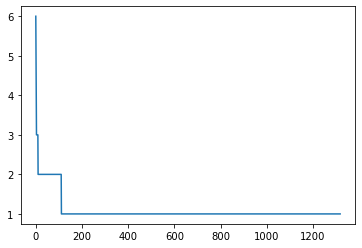

In [108]:
plt.plot(pd.Series(total_inhibitors+total_activators).value_counts().values)

In [109]:
pd.Series(total_inhibitors+total_activators).value_counts()[:20]

19920    6
16266    5
7965     4
5747     3
12708    3
4349     3
18373    3
19290    3
13418    3
6176     3
18999    2
14161    2
18750    2
20199    2
16727    2
10722    2
17662    2
157      2
6443     2
2739     2
dtype: int64

In [26]:
imp_cols

array([ 3282,  4000,  4731,  4829,  5160,  5248,  5607,  5620,  5927,
        6108,  6686,  6691,  6692,  6697,  6700,  6701,  6703,  6707,
        6720,  6721,  6722,  6724,  6728,  6731,  6736,  6737,  6743,
        6746,  6748,  6749,  6750,  6755,  6758,  6761,  6764,  7278,
        7324,  7602,  7674,  7757,  8221,  8729,  9313,  9584,  9890,
        9930, 10479, 10567, 10568, 10581, 10582, 10585, 10711, 10883,
       10916, 10935, 11287, 11376, 11575, 11640, 12986, 13364, 13775,
       14756, 15095, 15237, 15542, 16474, 17057, 17108, 17292, 17308,
       17481, 17483, 17719, 17794, 18404, 18417, 18627, 18729, 19461,
       19889, 20061, 20849])

In [112]:
[i for i in (total_inhibitors+total_activators) if i in imp_cols]

[9584, 17481, 7324, 6755, 4000]

In [113]:
pd.Series(total_inhibitors+total_activators).value_counts().index.tolist()

[19920, 16266, 7965, 5747, 12708, 4349, 18373, 19290, 13418, 6176]

In [99]:
abc = X_train[:,16266]

(array([2.2338e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4000e+01,
        2.0800e+02, 1.5320e+03, 1.4242e+04, 3.0019e+04, 2.6250e+03]),
 array([-1.4638828 , -1.2028073 , -0.9417318 , -0.68065625, -0.41958076,
        -0.15850526,  0.10257025,  0.36364576,  0.6247213 ,  0.8857968 ,
         1.1468723 ], dtype=float32),
 <BarContainer object of 10 artists>)

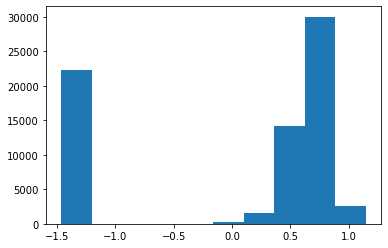

In [100]:
plt.hist(abc)

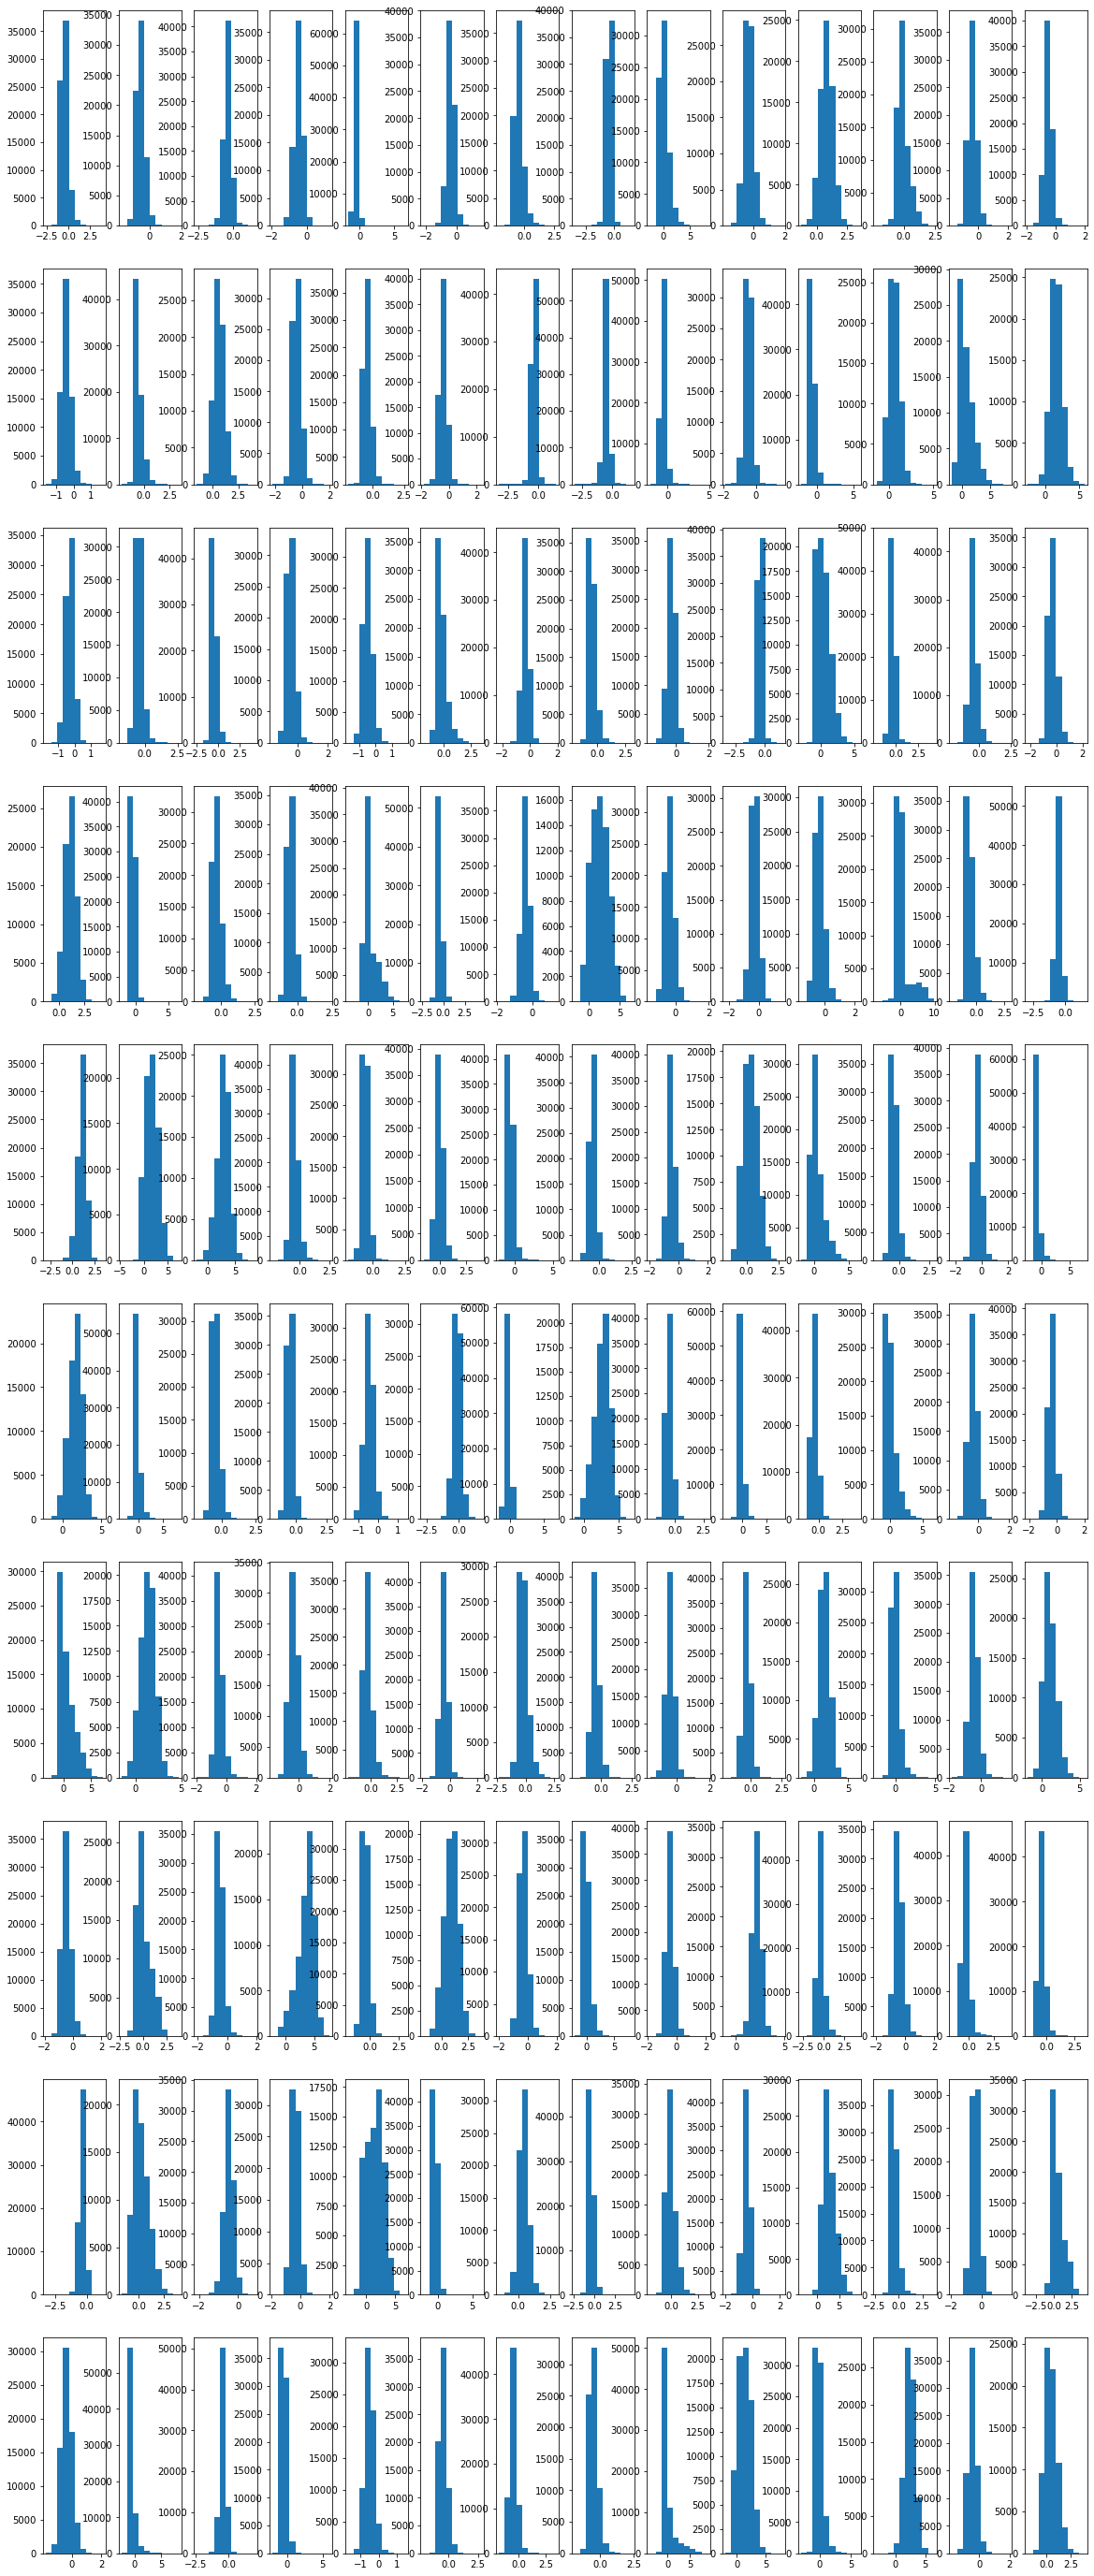

In [9]:
fig, ax = plt.subplots(10,14,figsize=(20,50))
for i in range(140):
    j = i %  10
    k = i // 10
    ax[j,k].hist(y_train[:,i])
fig.show()

In [94]:
X_train[:,16266].mean()

-3.1881213e-05

In [3]:
X_train_pca -= X_train_pca.mean(axis=0).reshape(1, -1)
X_train_pca /= X_train_pca.std(axis=0).reshape(1, -1)

In [4]:
X_train_pca.shape

(70988, 256)

In [9]:
1/np.sqrt(70988)

0.003753250314689879

In [28]:
from scipy.stats import rankdata, norm
def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    for i in range(len(fdr)-1):
        if fdr[i]>fdr[i+1]:
            fdr[i]=fdr[i+1]
        fdr[fdr > 1] = 1
    return fdr

def adjusted_p_values(z_scores):
    p_values = norm.sf(z_scores)*2 #twoside
    adjusted_p_values = fdr(p_values)
    adjusted_z_scores = norm.ppf(1-adjusted_p_values/2)
    return adjusted_z_scores

In [11]:
len(np.array(pos_index)[pos_label == 0])

161

In [13]:
len(np.array(neg_index)[neg_label == j])

41

In [14]:
1/np.sqrt(202)

0.07035975447302918

In [70]:
scipy.stats.norm.ppf(scipy.stats.norm.sf(2)/140)

-3.594510623195882

In [18]:
with np.load('./sparse/train_cite_targets_idxcol.npz',allow_pickle=True) as data:
    cell_columns = data['columns']

In [20]:
len(pd.Series(activator_rna_list))

238

In [78]:
pd.Series(inhibitor_prot_list)

CD86       [2, 3, 9, 10, 12, 13, 15, 16, 18, 22, 37, 40, ...
CD48                   [2, 5, 13, 18, 25, 38, 153, 199, 246]
CD3        [6, 10, 13, 16, 19, 82, 84, 113, 136, 151, 190...
CD8        [0, 1, 3, 7, 13, 16, 17, 18, 19, 23, 25, 106, ...
CD56       [9, 13, 15, 16, 30, 36, 40, 49, 60, 61, 68, 87...
                                 ...                        
TCRVd2     [3, 4, 9, 13, 16, 18, 30, 41, 79, 80, 129, 134...
CD158e1    [3, 9, 13, 18, 30, 44, 77, 89, 90, 103, 123, 1...
CD142      [2, 13, 37, 45, 46, 50, 67, 98, 118, 132, 141,...
CD162      [2, 25, 49, 61, 63, 65, 80, 147, 165, 172, 184...
CD328      [2, 5, 6, 9, 10, 12, 13, 14, 15, 17, 20, 35, 1...
Length: 62, dtype: object

In [76]:
print(np.mean([len(i) for i in pd.Series(activator_prot_list).values]))

13.016129032258064


In [15]:
X_train_pca[list(set(pos_index+neg_index))] -= X_train_pca[list(set(pos_index+neg_index))].mean(axis=0).reshape(1, -1)
X_train_pca[list(set(pos_index+neg_index))] /= X_train_pca[list(set(pos_index+neg_index))].std(axis=0).reshape(1, -1)

In [71]:
# standardizing X_train_pca and comparing to thresh
#n = 140
activator_rna_list = {}
inhibitor_rna_list = {}
activator_prot_list = {}
inhibitor_prot_list = {}
for j,prot in enumerate(cell_columns):
    if j == 104:
        continue
    thresh = 1.0
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    thresh /= np.sqrt(len(pos_index_j)+len(neg_index_j))
    thresh *= 3.59
    #print(thresh)
    if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
        print(f'Passing i = {j}')
        continue
#    ax[j,0].hist(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0),bins=100)
#    ax[j,0].axis(ymax=50)
    activators = [i for i, x in enumerate(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0) > thresh) if x]
    inhibitors = [i for i, x in enumerate(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0) < -thresh) if x]
    if len(activators) > 0:
        activator_prot_list[prot] = activators
    if len(inhibitors) > 0:
        inhibitor_prot_list[prot] = inhibitors
    for i in activators:
        if i not in activator_rna_list.keys():
            activator_rna_list[i] = [prot]
        else:
            activator_rna_list[i].append(prot)
    for i in inhibitors:
        if i not in inhibitor_rna_list.keys():
            inhibitor_rna_list[i] = [prot]
        else:
            inhibitor_rna_list[i].append(prot)    
    print(f'i = {j}, {len(activators)} activators')
    print(f'i = {j}, {len(activators)} inhibitors')

i = 0, 13 activators
i = 0, 13 inhibitors
Passing i = 1
Passing i = 2
Passing i = 3
Passing i = 4
Passing i = 5
i = 6, 9 activators
i = 6, 9 inhibitors
Passing i = 7
Passing i = 8
Passing i = 9
i = 10, 10 activators
i = 10, 10 inhibitors
i = 11, 13 activators
i = 11, 13 inhibitors
i = 12, 9 activators
i = 12, 9 inhibitors
i = 13, 11 activators
i = 13, 11 inhibitors
Passing i = 14
i = 15, 10 activators
i = 15, 10 inhibitors
Passing i = 16
i = 17, 4 activators
i = 17, 4 inhibitors
i = 18, 17 activators
i = 18, 17 inhibitors
i = 19, 10 activators
i = 19, 10 inhibitors
Passing i = 20
Passing i = 21
i = 22, 10 activators
i = 22, 10 inhibitors
i = 23, 16 activators
i = 23, 16 inhibitors
Passing i = 24
i = 25, 18 activators
i = 25, 18 inhibitors
i = 26, 11 activators
i = 26, 11 inhibitors
i = 27, 13 activators
i = 27, 13 inhibitors
Passing i = 28
Passing i = 29
Passing i = 30
i = 31, 10 activators
i = 31, 10 inhibitors
i = 32, 12 activators
i = 32, 12 inhibitors
i = 33, 14 activators
i = 33, 

In [69]:
#looking for pca outliers
import random
n = 140
pca_activator_modes = {}
pca_inhibitor_modes = {}
with open('pca_activ_inhib.txt', 'a') as the_file:
    for j in range(n):
        pos_index_j = np.array(pos_index)[pos_label == j]
        neg_index_j = np.array(neg_index)[neg_label == j]
        if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
            continue
        activators = []
        inhibitors = []
        pos_cutoff = 0
        neg_cutoff = 0
        cutoffs = []
        for k in range(20):
            ind_rand_pos = random.choices(pos_index, k=len(pos_index_j))
            ind_rand_neg = random.choices(neg_index, k=len(neg_index_j))
            cutoff = X_train_pca[ind_rand_pos].mean(axis=0) - X_train_pca[ind_rand_neg].mean(axis=0)
            cutoffs.append(cutoff)
        pos_cutoff = np.max(cutoffs,axis=0)
        neg_cutoff = np.min(cutoffs,axis=0)
        activators.append(len([i for i, x in enumerate(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0) > pos_cutoff) if x]))
        inhibitors.append(len([i for i, x in enumerate(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0) < neg_cutoff) if x]))
        pca_activator_modes[j] = np.min(activators)#statistics.mode(activators)
        pca_inhibitor_modes[j] = np.min(inhibitors)#statistics.mode(inhibitors)
        print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) pca activators')
        print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) pca inhibitors')
        the_file.write(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) pca activators\n')
        the_file.write(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) pca inhibitors\n')

i = 0, 14 (14-14) pca activators
i = 0, 16 (16-16) pca inhibitors
i = 6, 14 (14-14) pca activators
i = 6, 9 (9-9) pca inhibitors
i = 10, 16 (16-16) pca activators
i = 10, 12 (12-12) pca inhibitors
i = 11, 20 (20-20) pca activators
i = 11, 15 (15-15) pca inhibitors
i = 12, 13 (13-13) pca activators
i = 12, 16 (16-16) pca inhibitors
i = 13, 15 (15-15) pca activators
i = 13, 18 (18-18) pca inhibitors
i = 15, 8 (8-8) pca activators
i = 15, 13 (13-13) pca inhibitors
i = 17, 8 (8-8) pca activators
i = 17, 14 (14-14) pca inhibitors
i = 18, 18 (18-18) pca activators
i = 18, 16 (16-16) pca inhibitors
i = 19, 14 (14-14) pca activators
i = 19, 18 (18-18) pca inhibitors
i = 22, 11 (11-11) pca activators
i = 22, 16 (16-16) pca inhibitors
i = 23, 16 (16-16) pca activators
i = 23, 18 (18-18) pca inhibitors
i = 25, 19 (19-19) pca activators
i = 25, 10 (10-10) pca inhibitors
i = 26, 12 (12-12) pca activators
i = 26, 10 (10-10) pca inhibitors
i = 27, 12 (12-12) pca activators
i = 27, 16 (16-16) pca inhi

In [62]:
pca_total_inhibitors = []
pca_total_activators = []
for j in range(140):
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 50) or (len(neg_index_j) < 50):
        continue
    pca_total_inhibitors+=np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[:pca_inhibitor_modes[j]].tolist()
    if pca_activator_modes[j] == 0:
        continue
    else:
        pca_total_activators+=np.argsort(X_train_pca[pos_index_j].mean(axis=0) - X_train_pca[neg_index_j].mean(axis=0))[-pca_activator_modes[j]:].tolist()

In [63]:
print(len(pca_total_inhibitors))

44


In [64]:
print(len(set(pca_total_inhibitors)))

29


In [65]:
print(len(set(pca_total_activators)))

35


In [66]:
print(len(set(pca_total_activators+pca_total_inhibitors)))

58


In [67]:
abc = np.sort(list(set(pca_total_activators+pca_total_inhibitors)))

In [68]:
abc

array([  1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  14,  15,
        16,  18,  19,  20,  21,  22,  23,  26,  27,  30,  36,  39,  40,
        41,  42,  44,  45,  49,  51,  53,  54,  56,  68,  71,  88,  89,
        99, 101, 103, 104, 108, 111, 129, 132, 146, 147, 170, 171, 182,
       198, 207, 208, 220, 236, 238])

In [139]:
svd = TruncatedSVD(n_components=256)
_ = svd.fit(X_train)
X_train_pca[:,75:] = 0
no_pca_X_train = svd.inverse_transform(X_train_pca)

In [156]:
n = 140
no_pca_activator_modes = {}
no_pca_inhibitor_modes = {}
for j in range(n):
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) == 0) or (len(neg_index_j) == 0):
        continue
    activators = []
    inhibitors = []
    for k in range(100):
        ind_rand_pos = np.random.randint(low=0, high=len(pos_index), size=len(pos_index_j))
        ind_rand_neg = np.random.randint(low=0, high=len(neg_index), size=len(neg_index_j))
        pos_cutoff = np.max(no_pca_X_train[ind_rand_pos].mean(axis=0) - no_pca_X_train[ind_rand_neg].mean(axis=0))
        neg_cutoff = np.min(no_pca_X_train[ind_rand_pos].mean(axis=0) - no_pca_X_train[ind_rand_neg].mean(axis=0))
        activators.append(len([i for i, x in enumerate(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0) > pos_cutoff) if x]))
        inhibitors.append(len([i for i, x in enumerate(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0) < neg_cutoff) if x]))
    no_pca_activator_modes[j] = statistics.mode(activators)
    no_pca_inhibitor_modes[j] = statistics.mode(inhibitors)
    print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators')
    print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors')

NameError: name 'no_pca_X_train' is not defined

In [141]:
no_pca_total_inhibitors = []
no_pca_total_activators = []
for j in range(140):
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) == 0) or (len(neg_index_j) == 0):
        continue
    no_pca_total_inhibitors+=np.argsort(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0))[:inhibitor_modes[j]].tolist()
    if activator_modes[j] == 0:
        continue
    else:
        no_pca_total_activators+=np.argsort(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0))[-activator_modes[j]:].tolist()

In [142]:
pd.Series(no_pca_total_inhibitors+no_pca_total_activators).value_counts()[:20]

16266    38
9651     24
19920    21
4194     21
5116     21
6604     20
6226     19
5350     19
9880     18
11077    18
3963     18
17326    15
12526    15
9649     15
11764    14
12346    14
15718    13
9885     13
7965     13
14251    13
dtype: int64

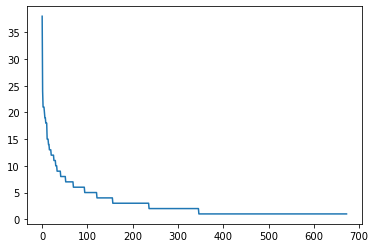

In [143]:
plt.plot(pd.Series(no_pca_total_inhibitors+no_pca_total_activators).value_counts().values)

In [144]:
np.savetxt('./pca256/new_imp_cols',pd.Series(no_pca_total_inhibitors+no_pca_total_activators).value_counts()[:50].index.tolist())

In [148]:
new_imp_cols = np.genfromtxt('./pca256/new_imp_cols').astype(int)

In [149]:
new_imp_cols

array([16266,  9651, 19920,  4194,  5116,  6604,  6226,  5350,  9880,
       11077,  3963, 17326, 12526,  9649, 11764, 12346, 15718,  9885,
        7965, 14251, 16423, 16136, 17622, 10262, 10833, 19776,  6359,
        4949, 16185,  6278, 10006, 14747,  7098,  5422, 19362,  4933,
       11477, 16079,  8664,  5351,  9725, 16192,  9795, 12983,  7053,
        7881,  9560, 16158,  9951,  5107])

In [146]:
imp_cols

array([ 3282,  4000,  4731,  4829,  5160,  5248,  5607,  5620,  5927,
        6108,  6686,  6691,  6692,  6697,  6700,  6701,  6703,  6707,
        6720,  6721,  6722,  6724,  6728,  6731,  6736,  6737,  6743,
        6746,  6748,  6749,  6750,  6755,  6758,  6761,  6764,  7278,
        7324,  7602,  7674,  7757,  8221,  8729,  9313,  9584,  9890,
        9930, 10479, 10567, 10568, 10581, 10582, 10585, 10711, 10883,
       10916, 10935, 11287, 11376, 11575, 11640, 12986, 13364, 13775,
       14756, 15095, 15237, 15542, 16474, 17057, 17108, 17292, 17308,
       17481, 17483, 17719, 17794, 18404, 18417, 18627, 18729, 19461,
       19889, 20061, 20849])

In [147]:
len(imp_cols)

84

In [150]:
len(new_imp_cols)

50

In [19]:
np.argsort(abc)[::-1]

array([ 37,  24, 108,  75, 119,  97,  73,  14,   5, 131, 106,  48,  99,
        16,   3, 136,   4,  57, 100, 121,  21,   6, 111, 138, 104, 139,
        68, 102, 113,  43,  94,  18,  80,  89,  17, 115,  77, 116,  54,
       110,  88, 109,  55,  66,  52,  46,  82,  90, 127,  67,   2, 132,
        93,  36,  15,   9,  38, 103,  62,  23,  65, 124, 135,  96, 112,
       125,   8, 107,  61,  50,  83, 105,  86,  47,  20,  39, 137,  63,
        31, 120,  41,  13,  92,  12,  95, 128,  19, 117,  76,   1,  56,
       129,  34,  29,  45,  32,   0,  51,  33,  11,  59, 114,  98,  72,
        70, 118,  87,   7, 126, 122,  30,  42,  78,  91,  79,  25,  28,
        64,  69,  60,  58, 123,  49,  85,  40,  35, 130,  71,  74,  81,
        22,  27,  84, 133, 134,  53,  26, 101,  44,  10])

In [11]:
abc = np.array(y_train.mean(axis=0))[0]
imp_prot = [i for i,x in enumerate(abc>-0.2) if x]
svd = TruncatedSVD(n_components=256)
_ = svd.fit(X_train)
X_train_pca[:,75:] = 0
no_pca_X_train = svd.inverse_transform(X_train_pca)

In [31]:
imp_prot = [i for i,x in enumerate(abc>1.0) if x]

In [32]:
len(imp_prot)

17

In [41]:
thresh = 0.75
no_pca_activator_modes = {}
no_pca_inhibitor_modes = {}
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 25) or (len(neg_index_j) < 25):
        print(f'Passing i = {j}')
        continue
    activators = []
    inhibitors = []
    activators.append(len([i for i, x in enumerate(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0) > thresh) if x]))
    inhibitors.append(len([i for i, x in enumerate(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0) < -thresh) if x]))
    no_pca_activator_modes[j] = statistics.mode(activators)
    no_pca_inhibitor_modes[j] = statistics.mode(inhibitors)
    print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators')
    print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors')

Passing i = 3
Passing i = 4
Passing i = 5
i = 14, 1 (1-1) activators
i = 14, 2 (2-2) inhibitors
Passing i = 16
i = 24, 1 (1-1) activators
i = 24, 0 (0-0) inhibitors
Passing i = 37
i = 48, 0 (0-0) activators
i = 48, 0 (0-0) inhibitors
i = 73, 0 (0-0) activators
i = 73, 0 (0-0) inhibitors
Passing i = 75
Passing i = 97
Passing i = 99
Passing i = 106
i = 108, 0 (0-0) activators
i = 108, 0 (0-0) inhibitors
Passing i = 119
i = 131, 1 (1-1) activators
i = 131, 2 (2-2) inhibitors
Passing i = 136


In [45]:
no_pca_total_inhibitors = []
no_pca_total_activators = []
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 25) or (len(neg_index_j) < 25):
        continue
    no_pca_total_inhibitors+=np.argsort(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0))[:no_pca_inhibitor_modes[j]].tolist()
    if no_pca_activator_modes[j] == 0:
        continue
    else:
        no_pca_total_activators+=np.argsort(no_pca_X_train[pos_index_j].mean(axis=0) - no_pca_X_train[neg_index_j].mean(axis=0))[-no_pca_activator_modes[j]:].tolist()

In [48]:
no_pca_total_inhibitors + no_pca_total_activators

[4933, 13385, 3963, 14747, 3963, 5116, 9885]

In [47]:
no_pca_total_activators

[3963, 5116, 9885]

In [49]:
X_train[X_train == 0.0] = np.nan
X_train

array([[      nan,       nan,       nan, ...,       nan, 4.090185 ,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ..., 3.8473213, 3.8473213,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 4.497696 ,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
        3.9009068],
       [      nan,       nan,       nan, ...,       nan, 4.1895022,
        4.1895022]], dtype=float32)

In [59]:
thresh = 1.8
activator_modes = {}
inhibitor_modes = {}
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 25) or (len(neg_index_j) < 25):
        print(f'Passing i = {j}')
        continue
#    ax[j,0].hist(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0),bins=100)
#    ax[j,0].axis(ymax=50)
    activators = []
    inhibitors = []
    activators.append(len([i for i, x in enumerate(np.nanmean(X_train[pos_index_j],axis=0) - np.nanmean(X_train[neg_index_j],axis=0) > thresh) if x]))
    inhibitors.append(len([i for i, x in enumerate(np.nanmean(X_train[pos_index_j],axis=0) - np.nanmean(X_train[neg_index_j],axis=0) < -thresh) if x]))
    activator_modes[j] = statistics.mode(activators)
    inhibitor_modes[j] = statistics.mode(inhibitors)
    print(f'i = {j}, {statistics.mode(activators)} ({np.min(activators)}-{np.max(activators)}) activators')
    print(f'i = {j}, {statistics.mode(inhibitors)} ({np.min(inhibitors)}-{np.max(inhibitors)}) inhibitors')

Passing i = 3
Passing i = 4
Passing i = 5
i = 14, 0 (0-0) activators
i = 14, 1 (1-1) inhibitors
Passing i = 16
i = 24, 1 (1-1) activators
i = 24, 1 (1-1) inhibitors
Passing i = 37
i = 48, 0 (0-0) activators
i = 48, 1 (1-1) inhibitors
i = 73, 0 (0-0) activators
i = 73, 0 (0-0) inhibitors
Passing i = 75
Passing i = 97
Passing i = 99
Passing i = 106


/tmp/ipykernel_393/1819683361.py:14: RuntimeWarning: Mean of empty slice
  activators.append(len([i for i, x in enumerate(np.nanmean(X_train[pos_index_j],axis=0) - np.nanmean(X_train[neg_index_j],axis=0) > thresh) if x]))
/tmp/ipykernel_393/1819683361.py:15: RuntimeWarning: Mean of empty slice
  inhibitors.append(len([i for i, x in enumerate(np.nanmean(X_train[pos_index_j],axis=0) - np.nanmean(X_train[neg_index_j],axis=0) < -thresh) if x]))


i = 108, 1 (1-1) activators
i = 108, 0 (0-0) inhibitors
Passing i = 119
i = 131, 2 (2-2) activators
i = 131, 2 (2-2) inhibitors
Passing i = 136


In [60]:
total_inhibitors = []
total_activators = []
for j in imp_prot:
    pos_index_j = np.array(pos_index)[pos_label == j]
    neg_index_j = np.array(neg_index)[neg_label == j]
    if (len(pos_index_j) < 25) or (len(neg_index_j) < 25):
        continue
    total_inhibitors+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[:inhibitor_modes[j]].tolist()
    if activator_modes[j] == 0:
        continue
    else:
        total_activators+=np.argsort(X_train[pos_index_j].mean(axis=0) - X_train[neg_index_j].mean(axis=0))[-activator_modes[j]:].tolist()

In [61]:
total_inhibitors+total_activators

[7333, 14601, 9839, 17697, 6195, 20855, 20855, 6971, 20855]

In [1]:
"""TensorFlow 2.0 implementation of vanilla Autoencoder."""
import numpy as np
import tensorflow as tf

__author__ = "Abien Fred Agarap"

np.random.seed(1)
tf.random.set_seed(1)
batch_size = 128
epochs = 10
learning_rate = 1e-2
intermediate_dim = 64
original_dim = 784

X_train
(training_features, _), _ = tf.keras.datasets.mnist.load_data()
training_features = training_features / np.max(training_features)
training_features = training_features.reshape(training_features.shape[0],
                                              training_features.shape[1] * training_features.shape[2])
training_features = training_features.astype('float32')

training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)


class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim):
    super(Encoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.silu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.sigmoid
    )
    
  def call(self, input_features):
    activation = self.hidden_layer(input_features)
    return self.output_layer(activation)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Decoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.silu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=original_dim,
      activation=tf.nn.sigmoid
    )
  
  def call(self, code):
    activation = self.hidden_layer(code)
    return self.output_layer(activation)
  
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      original_dim=original_dim
    )
  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  original_dim=original_dim
)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error
  
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in range(epochs):
      for step, batch_features in enumerate(training_dataset):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        original = tf.reshape(batch_features, (batch_features.shape[0], 28, 28, 1))
        reconstructed = tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 28, 28, 1))
        tf.summary.scalar('loss', loss_values, step=step)
        tf.summary.image('original', original, max_outputs=10, step=step)
        tf.summary.image('reconstructed', reconstructed, max_outputs=10, step=step)

2022-10-20 22:11:46.974948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 22:11:47.111053: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 22:11:47.147406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 22:11:47.705349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

11490434/11490434 [==============================] - 0s 0us/step


2022-10-20 22:11:49.514951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 22:11:49.522397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-20 22:11:49.522416: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-20 22:11:49.522842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

In [2]:
%load_ext tensorboard

In [7]:
tensorboard --logdir=tmp/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 394), started 0:10:47 ago. (Use '!kill 394' to kill it.)

In [25]:
"""TensorFlow 2.0 implementation of vanilla Autoencoder."""
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)
batch_size = 512
epochs = 10
learning_rate = 1e-3
intermediate_dim = 64
original_dim = 64

# (training_features, _), _ = tf.keras.datasets.mnist.load_data()
# training_features = training_features / np.max(training_features)
# training_features = training_features.reshape(training_features.shape[0],
#                                               training_features.shape[1] * training_features.shape[2])
# training_features = training_features.astype('float32')


training_features = abc.transform(X_train)

training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)


class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim):
    super(Encoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.silu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.sigmoid
    )
    
  def call(self, input_features):
    activation = self.hidden_layer(input_features)
    return self.output_layer(activation)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Decoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.silu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=original_dim,
      activation=tf.nn.sigmoid
    )
  
  def call(self, code):
    activation = self.hidden_layer(code)
    return self.output_layer(activation)
  
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      original_dim=original_dim
    )
  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  original_dim=original_dim
)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

def loss(model, original):
  return negative_correlation_loss(model(original), original)
  
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in range(epochs):
      for step, batch_features in enumerate(training_dataset):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        original = batch_features #tf.reshape(batch_features, (batch_features.shape[0], 28, 28, 1))
        reconstructed = autoencoder(tf.constant(batch_features))#tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 28, 28, 1))
      print(loss_values)

tf.Tensor(-0.11855693, shape=(), dtype=float32)
tf.Tensor(-0.1297744, shape=(), dtype=float32)
tf.Tensor(-0.13097, shape=(), dtype=float32)
tf.Tensor(-0.13209277, shape=(), dtype=float32)
tf.Tensor(-0.12941386, shape=(), dtype=float32)
tf.Tensor(-0.13160633, shape=(), dtype=float32)
tf.Tensor(-0.13460797, shape=(), dtype=float32)
tf.Tensor(-0.13400559, shape=(), dtype=float32)
tf.Tensor(-0.12816295, shape=(), dtype=float32)
tf.Tensor(-0.13537009, shape=(), dtype=float32)


In [17]:
abc = TruncatedSVD(n_components=64)
abc.fit(X_train)

TruncatedSVD(n_components=64)

In [19]:
correlation_score(abc.inverse_transform(abc.transform(X_train)),X_train)

0.7887054586414354

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (70988, 140) instead.

In [29]:
from prinpy.glob import NLPCA

In [28]:
!pip install prinpy

In [30]:
pca = NLPCA()

In [46]:
from tensorflow.keras import Sequential
m = Sequential()
m.add(Dense(1024,  activation='elu', input_shape=(21601,)))
m.add(Dense(256,  activation='elu'))
m.add(Dense(64,    activation='linear', name="bottleneck"))
m.add(Dense(256,  activation='elu'))
m.add(Dense(1024,  activation='elu'))
m.add(Dense(21601,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam())
history = m.fit(X_train, X_train, batch_size=128, epochs=1, verbose=1)

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(X_train[:1000])
Renc = m.predict(X_train[:1000])

32/32 [==============================] - 0s 8ms/step


In [42]:
X_train[0][:100]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 4.090185 ,
       4.774929 , 0.       , 4.090185 , 0.       , 0.       , 0.       ,
       0.       , 4.090185 , 5.463848 , 0.       , 0.       , 4.774929 ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 4.090185 , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       4.774929 , 0.       , 4.774929 , 5.1775775, 4.090185 , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 4.090185 , 0.       , 0.       , 4.774929 , 0.       ,
       0.       , 0.       , 4.090185 , 4.774929 , 0.       , 0.       ,
       0.       , 4.090185 , 0.       , 0.       , 

In [47]:
Renc[0][:100]

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [48]:
Zenc[0]

array([-1.9001250e+02, -1.9210846e+02,  2.6705991e+02, -3.8150000e+02,
       -2.2302948e+02, -1.6921252e+02, -4.5942707e+01, -3.5964436e+01,
        1.5000304e+02,  3.5812631e+02,  4.3256018e+02, -4.5294388e+02,
       -5.0763690e-01,  2.2213867e+01,  3.8872066e+01, -2.4511826e+02,
       -1.3159393e+02,  6.5987549e+02, -1.0924787e+01,  2.0539487e+02,
       -2.9750262e+02, -1.4894931e+02,  1.4882059e+02,  8.9962530e+00,
       -2.6671431e+01, -1.2724341e+02, -1.5829343e+02,  3.5271405e+02,
       -8.9720270e+02,  7.8685046e+02, -6.3890503e+01,  6.7496710e+02,
       -8.8161179e+01,  4.8237701e+01, -2.4809853e+02,  2.7556049e+02,
        7.0641620e+02, -3.3719998e+02,  7.9041785e+02,  1.0730234e+02,
        1.3350258e+02, -8.6173273e+02,  1.3401464e+01, -2.5735526e+02,
       -2.4429985e+02, -2.9307447e+01, -3.7385922e+02,  7.4416046e+01,
       -8.4874168e+01,  4.1837585e+02, -8.4668541e+00, -3.2080719e+02,
        2.8162308e+02, -5.4468646e+02, -2.2979726e+02, -1.8220692e+02,
      

In [50]:
correlation_score(m.predict(X_train[:10000]),X_train[:10000])

313/313 [==============================] - 3s 9ms/step


0.5545271374425317

In [2]:
from tensorflow.keras import Sequential
m = Sequential()
m.add(Dense(1024,  activation='silu', input_shape=(21601,)))
m.add(Dense(64,    activation='linear', name="bottleneck"))
m.add(Dense(1024,  activation='silu'))
m.add(Dense(21601,  activation='silu'))
m.compile(loss=negative_correlation_loss, optimizer = tf.keras.optimizers.Adam())
history = m.fit(X_train, X_train, batch_size=128, epochs=2, verbose=1)

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(X_train[:1000])
Renc = m.predict(X_train[:1000])

2022-10-21 00:05:17.595526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 00:05:17.596470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-21 00:05:17.596490: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-21 00:05:17.598033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

Epoch 1/2
555/555 [==============================] - 33s 58ms/step - loss: -1.4369
Epoch 2/2
32/32 [==============================] - 0s 9ms/step


In [55]:
correlation_score(m.predict(X_train[:1000]),X_train[:1000])

32/32 [==============================] - 0s 10ms/step


0.6406379173950614

In [ ]:
correlation_score(m.predict(X_train[:1000]),X_train[:1000])

32/32 [==============================] - 0s 9ms/step


0.7854950645470599

In [3]:
correlation_score(m.predict(X_train[:1000]),X_train[:1000])

32/32 [==============================] - 0s 9ms/step


0.7889109247051851

In [4]:
correlation_score(m.predict(X_train),X_train)

2219/2219 [==============================] - 20s 9ms/step


0.7705255787310847

PCA: 0.7887054586414354

In [24]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
X_train -= X_train.mean(axis=0).reshape(1, -1)
X_train /= X_train.std(axis=0).reshape(1, -1)

(array([1.5947e+04, 2.9559e+04, 1.3138e+04, 8.5090e+03, 3.6190e+03,
        2.0700e+02, 7.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 10.863896,  23.408495,  35.95309 ,  48.49769 ,  61.04229 ,
         73.58688 ,  86.131485,  98.67608 , 111.22068 , 123.765274,
        136.30988 ], dtype=float32),
 <BarContainer object of 10 artists>)

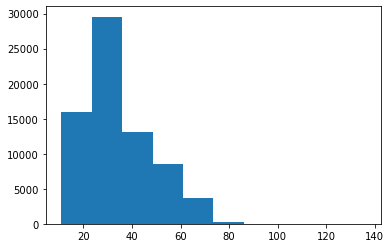

In [26]:
import matplotlib.pyplot as plt
plt.hist(np.max(X_train,axis=1))

(array([13793., 12793.,  6270.,  4879.,  5823.,  5676.,  5253.,  7835.,
         5072.,  3594.]),
 array([2.00000e+00, 2.15840e+03, 4.31480e+03, 6.47120e+03, 8.62760e+03,
        1.07840e+04, 1.29404e+04, 1.50968e+04, 1.72532e+04, 1.94096e+04,
        2.15660e+04]),
 <BarContainer object of 10 artists>)

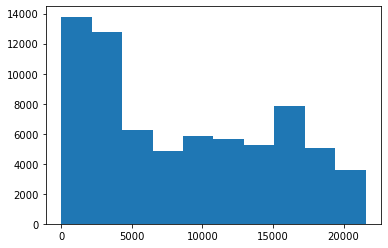

In [32]:
plt.hist(np.argmax(X_train,axis=1))

In [31]:
np.sort(X_train[0])[-100:]

array([ 3.7648747,  3.768705 ,  3.79323  ,  3.815614 ,  3.82468  ,
        3.8258672,  3.8349864,  3.83611  ,  3.8488488,  3.8645608,
        3.8683896,  3.8857658,  3.9234445,  3.9595516,  3.9887564,
        4.0129943,  4.0141854,  4.036542 ,  4.1499963,  4.172108 ,
        4.232586 ,  4.285995 ,  4.2979074,  4.3086953,  4.3512383,
        4.3898273,  4.3925753,  4.393155 ,  4.3955755,  4.3957086,
        4.410823 ,  4.4232345,  4.432514 ,  4.4386144,  4.442737 ,
        4.4472814,  4.528989 ,  4.536063 ,  4.644891 ,  4.6551523,
        4.678969 ,  4.685548 ,  4.6978726,  4.7413955,  4.74942  ,
        4.865137 ,  4.9324927,  4.936272 ,  4.957887 ,  5.0753407,
        5.0972414,  5.123781 ,  5.203505 ,  5.296024 ,  5.311109 ,
        5.342075 ,  5.343244 ,  5.482333 ,  5.5354657,  5.593158 ,
        5.596671 ,  5.7370725,  5.9233646,  6.146934 ,  6.327788 ,
        6.4867005,  6.6329336,  6.643274 ,  7.0794744,  7.0914993,
        7.1390433,  7.5181947,  7.6265945,  7.7093124,  7.7951

In [29]:
np.argsort(X_train[0])[-100:]

array([18262, 19072, 19738, 14877,  3603,   665,  2909,  4406, 10699,
        1362,  8841,  8339, 11075, 17204, 21219, 15104,  2642, 14929,
       12037,  2321,  4535, 11496, 12257,  5884,  7885, 11196, 17020,
       18372, 21487, 16072,  3721,  5283, 20181, 19185,  7911,  5399,
        3399, 12451, 12833, 20946,  9827, 19746,  1666, 19741,  8597,
        2873, 18145, 19318,  4563,  9823, 10663, 10114, 13452,  2248,
       17255, 19992,  4865,  4330,  3820, 15249, 16866,  4332, 14553,
       10031,  2406,  3611,   699,    74,  2389, 17877,  4472, 18594,
        9009,  4232,  2551,  3589,  8064,  1811, 11503,  8499,  9510,
        4188,  2590, 14787, 14044,   416,  2009,   535,   761,  1805,
        3426,   374, 20429,   641,   175,  3294,  3957,   772, 11685,
        7736])

In [30]:
X_train[:,7736]

array([ 3.4033245e+01, -3.1561948e-02, -3.1561948e-02, ...,
       -3.1561948e-02, -3.1561948e-02, -3.1561948e-02], dtype=float32)

In [33]:
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
y_train -= y_train.mean(axis=0).reshape(1, -1)
y_train /= y_train.std(axis=0).reshape(1, -1)

(array([4.3000e+01, 4.0200e+02, 4.1240e+03, 1.0438e+04, 1.4231e+04,
        1.2624e+04, 9.7850e+03, 6.5370e+03, 4.1290e+03, 2.5700e+03,
        1.6090e+03, 1.0070e+03, 7.7800e+02, 5.5000e+02, 3.8200e+02,
        2.8900e+02, 2.3000e+02, 1.8600e+02, 1.4900e+02, 1.2800e+02,
        8.9000e+01, 8.8000e+01, 6.1000e+01, 5.5000e+01, 4.2000e+01,
        4.7000e+01, 3.6000e+01, 2.8000e+01, 3.8000e+01, 2.3000e+01,
        3.0000e+01, 2.2000e+01, 1.4000e+01, 1.7000e+01, 1.8000e+01,
        1.6000e+01, 1.1000e+01, 9.0000e+00, 1.3000e+01, 1.2000e+01,
        1.5000e+01, 7.0000e+00, 8.0000e+00, 1.2000e+01, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 8.0000e+00,
        3.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.00

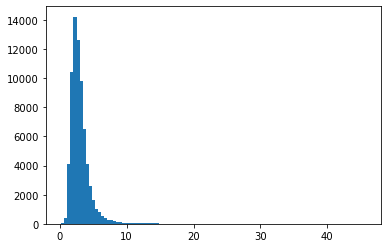

In [39]:
import matplotlib.pyplot as plt
plt.hist(np.max(y_train,axis=1),bins = 100)

In [49]:
abc = y_train[np.array(np.max(y_train,axis=1)>2).ravel()]

(array([1.3576e+04, 1.2494e+04, 9.9620e+03, 6.9060e+03, 4.4800e+03,
        2.7960e+03, 1.8410e+03, 1.1250e+03, 8.3200e+02, 6.2500e+02,
        4.3000e+02, 3.2900e+02, 2.4700e+02, 2.0400e+02, 1.5500e+02,
        1.3200e+02, 1.2000e+02, 8.7000e+01, 8.0000e+01, 5.5000e+01,
        5.2000e+01, 4.1000e+01, 4.4000e+01, 3.6000e+01, 2.7000e+01,
        3.6000e+01, 2.5000e+01, 2.6000e+01, 2.2000e+01, 1.8000e+01,
        1.4000e+01, 1.8000e+01, 1.4000e+01, 1.2000e+01, 1.0000e+01,
        1.4000e+01, 1.0000e+01, 1.0000e+01, 1.1000e+01, 7.0000e+00,
        1.2000e+01, 8.0000e+00, 5.0000e+00, 5.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

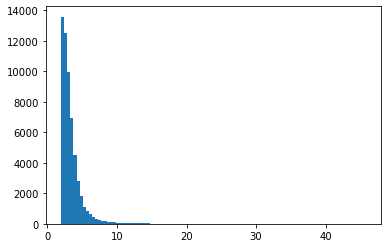

In [50]:
plt.hist(np.max(abc,axis=1),bins = 100)

(array([ 6763.,  9270.,  6610.,  6698.,  5313.,  6991.,  6790.,  7734.,
        10106.,  4713.]),
 array([  0. ,  13.9,  27.8,  41.7,  55.6,  69.5,  83.4,  97.3, 111.2,
        125.1, 139. ]),
 <BarContainer object of 10 artists>)

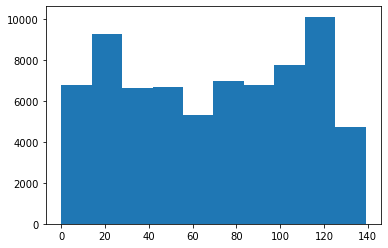

In [35]:
plt.hist(np.argmax(y_train,axis=1))

(array([ 993.,  312.,   84.,   92.,   37.,  130.,  926.,  370.,   54.,
         418.,  834., 1267.,  892.,  354.,  325.,  716.,  184.,  557.,
         751., 1722.,  276.,   35., 1213.,  651.,  262.,  714., 1141.,
         723.,  109.,  128.,  205.,  776.,  736.,  884., 1286.,  396.,
         181.,   78.,  120.,  939.,  276.,  496.,  326.,  437.,  544.,
         260.,  582.,  388.,  476.,  412.,   91.,  439.,  957., 1401.,
         187.,  198.,  273.,  132.,  557.,  758., 1049.,   30.,   73.,
         173.,  645.,  375.,  392.,  401.,   37.,  418.,  117.,  126.,
         845.,  323.,  381.,   95.,  597.,  964.,  959.,  599.,  937.,
         602.,  125.,  321., 1143., 1106.,  127.,  408.,  165., 1488.,
         107.,  224.,   79.,  106.,  259., 1306.,  268.,    4.,  303.,
         224.,   76., 1270.,  941.,  316., 1586.,  468.,   95., 1159.,
         569.,  459.,   79.,  189.,  103., 1682.,  543., 1509.,  767.,
         648., 1091.,   70.,  353.,  477.,  858., 1404.,  261.,  340.,
      

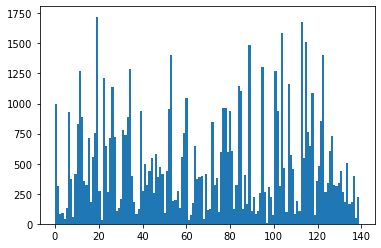

In [51]:
plt.hist(np.argmax(y_train,axis=1),bins=140)

(array([ 870.,  231.,   53.,   81.,   28.,   89.,  735.,  254.,   44.,
         345.,  613., 1087.,  799.,  266.,  256.,  615.,  137.,  382.,
         606., 1626.,  212.,   34.,  932.,  567.,  142.,  491.,  856.,
         521.,   90.,   92.,  146.,  512.,  519.,  560.,  908.,  278.,
         140.,   44.,   97.,  782.,  185.,  383.,  232.,  390.,  360.,
         182.,  505.,  294.,  263.,  292.,   73.,  345.,  921., 1243.,
         174.,  173.,  208.,  119.,  391.,  592.,  885.,   27.,   60.,
         135.,  565.,  310.,  355.,  330.,   34.,  331.,   98.,  104.,
         668.,  245.,  241.,   63.,  449.,  872.,  747.,  435.,  766.,
         484.,  114.,  244.,  756.,  726.,   89.,  283.,  156., 1431.,
          87.,  157.,   68.,   85.,  245., 1027.,  214.,    3.,  204.,
         154.,   69., 1123.,  734.,  251., 1355.,  351.,   83., 1014.,
         393.,  434.,   64.,  140.,   88., 1610.,  403., 1318.,  708.,
         486.,  938.,   54.,  262.,  355.,  648., 1213.,  198.,  267.,
      

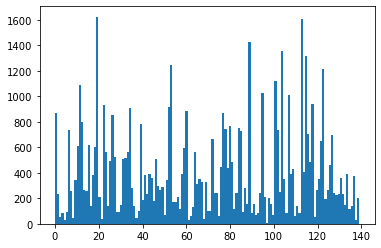

In [52]:
plt.hist(np.argmax(abc,axis=1),bins=140)

In [59]:
np.array(np.argmax(y_train,axis=1) == 0).ravel()

array([False, False, False, ..., False, False, False])

In [63]:
ind_0 = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == 0).ravel()) if x]

In [61]:
y_train[np.array(np.argmax(y_train,axis=1) == 0).ravel()].shape

(993, 140)

In [64]:
X_train[ind_0].mean(axis=0)

array([-0.01381254,  0.06116306,  0.00094562, ..., -0.05814992,
        0.22529916,  0.06333978], dtype=float32)

(array([1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 1.200e+01, 5.000e+00, 3.000e+00, 5.000e+00,
        1.500e+01, 2.100e+01, 2.000e+01, 2.600e+01, 2.900e+01, 2.800e+01,
        4.600e+01, 6.900e+01, 6.400e+01, 7.600e+01, 1.420e+02, 1.890e+02,
        2.380e+02, 4.070e+02, 6.860e+02, 1.160e+03, 1.867e+03, 2.503e+03,
        2.174e+03, 2.198e+03, 1.855e+03, 1.643e+03, 1.275e+03, 1.003e+03,
        8.120e+02, 6.200e+02, 4.800e+02, 3.570e+02, 2.820e+02, 2.140e+02,
        1.990e+02, 1.450e+02, 1.230e+02, 8.500e+01, 7.500e+01, 7.000e+01,
        4.900e+01, 4.600e+01, 3.700e+01, 2.700e+01, 2.400e+01, 2.300e+01,
        2.500e+01, 1.700e+01, 1.600e+01, 1.100e+01, 1.300e+01, 1.000e+01,
        6.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

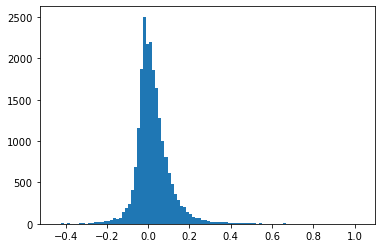

In [67]:
plt.hist(X_train[ind_0].mean(axis=0) - X_train.mean(axis=0),bins=100)

In [69]:
np.sort(X_train[ind_0].mean(axis=0) - X_train.mean(axis=0))[-100:]

array([0.38521814, 0.3856601 , 0.38722488, 0.38782263, 0.38830206,
       0.38845703, 0.38908738, 0.39013326, 0.39187485, 0.39200848,
       0.39217687, 0.393756  , 0.39420703, 0.39515153, 0.39703012,
       0.39837047, 0.40188816, 0.4056668 , 0.40582833, 0.40589052,
       0.40704077, 0.4098286 , 0.41027272, 0.41098475, 0.4119051 ,
       0.41447237, 0.4161768 , 0.41692907, 0.41727325, 0.41746333,
       0.4186507 , 0.4206978 , 0.42293283, 0.42428604, 0.4253196 ,
       0.4279162 , 0.42865855, 0.43054107, 0.43091175, 0.43122116,
       0.43727642, 0.43754333, 0.43872494, 0.442698  , 0.4458942 ,
       0.44665378, 0.4498773 , 0.4520538 , 0.45253673, 0.45282736,
       0.4571155 , 0.46162203, 0.46253952, 0.4638873 , 0.46503454,
       0.46639693, 0.468506  , 0.4702668 , 0.47315487, 0.47826716,
       0.47967994, 0.48036912, 0.48311114, 0.4861702 , 0.48996294,
       0.4933594 , 0.49770093, 0.50088364, 0.5016292 , 0.5132671 ,
       0.5145503 , 0.51757425, 0.51862144, 0.5247989 , 0.53102

(0.0, 15.0)

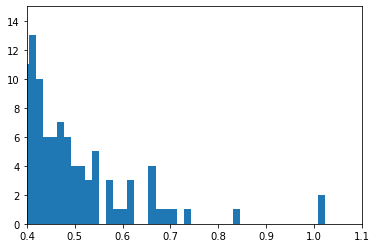

In [73]:
plt.hist(X_train[ind_0].mean(axis=0) - X_train.mean(axis=0),bins=100)
plt.xlim(0.4,1.1)
plt.ylim(0,15)

In [8]:
highly_variable

array([-1, -1, -1, ..., -1, -1, -1])

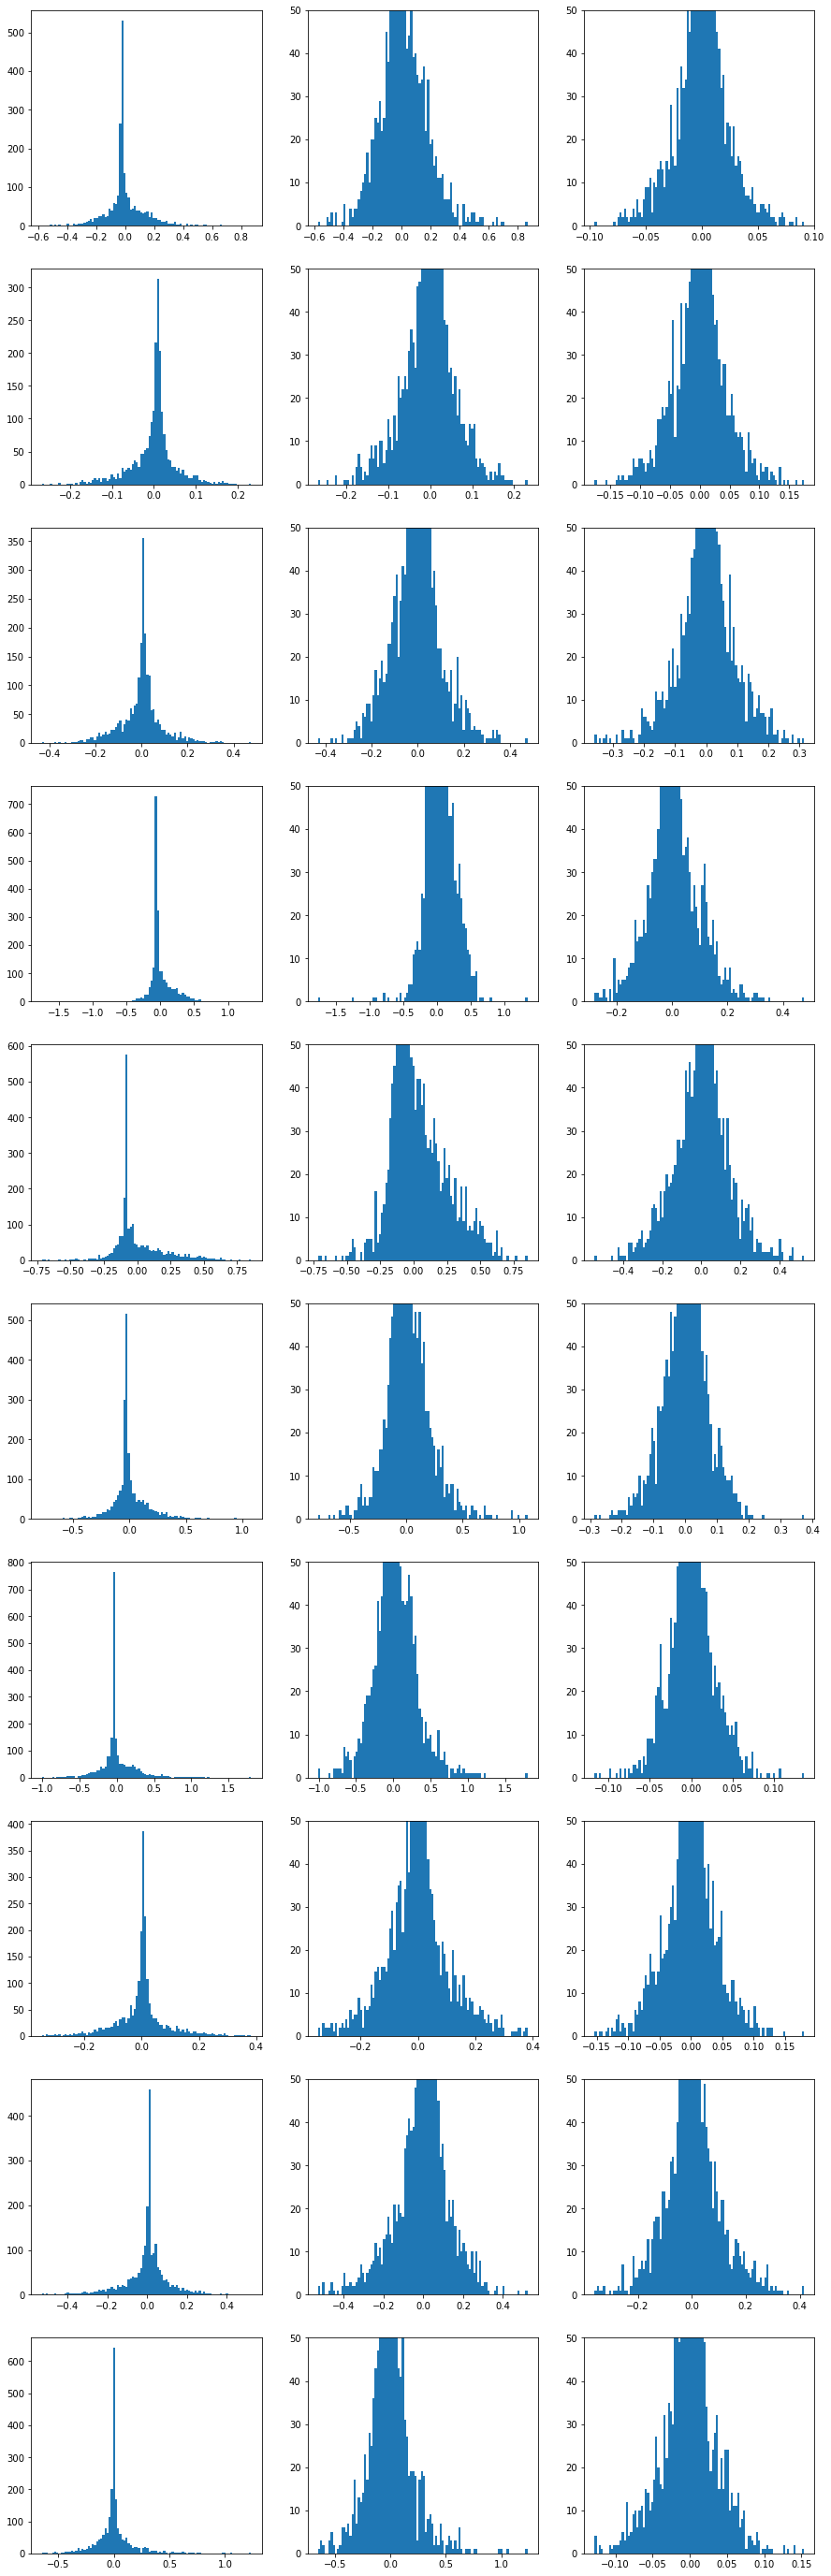

In [48]:
# X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
# to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
# X_train = delete_columns_csr(X_train,to_drop)
# X_train = X_train.toarray()
# highly_variable = np.genfromtxt('./sparse/highly_variable.csv',delimiter=',').astype(int)
# X_train = X_train[:,highly_variable]
# y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# y_train -= y_train.mean(axis=0).reshape(1, -1)
# y_train /= y_train.std(axis=0).reshape(1, -1)
# X_train -= X_train.mean(axis=1).reshape(-1, 1)
# X_train /= X_train.std(axis=1).reshape(-1, 1)
fig, ax = plt.subplots(10,3,figsize = (15,50))
for j in range(10):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    ax[j,0].hist(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0),bins=100)
    ax[j,1].hist(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0),bins=100)
    ax[j,1].axis(ymax=50)
    ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
    ax[j,2].hist(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0),bins=100)
    ax[j,2].axis(ymax=50)

In [55]:
for j in range(10):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) > np.max(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) < np.min(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} inhibitors')

i = 0, 313 activators
i = 0, 323 inhibitors
i = 1, 9 activators
i = 1, 16 inhibitors
i = 2, 1 activators
i = 2, 5 inhibitors
i = 3, 138 activators
i = 3, 32 inhibitors
i = 4, 26 activators
i = 4, 4 inhibitors
i = 5, 71 activators
i = 5, 112 inhibitors
i = 6, 483 activators
i = 6, 365 inhibitors
i = 7, 105 activators
i = 7, 78 inhibitors
i = 8, 4 activators
i = 8, 11 inhibitors
i = 9, 221 activators
i = 9, 287 inhibitors


In [56]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
# highly_variable = np.genfromtxt('./sparse/highly_variable.csv',delimiter=',').astype(int)
# X_train = X_train[:,highly_variable]
# y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# y_train -= y_train.mean(axis=0).reshape(1, -1)
# y_train /= y_train.std(axis=0).reshape(1, -1)
# X_train -= X_train.mean(axis=1).reshape(-1, 1)
# X_train /= X_train.std(axis=1).reshape(-1, 1)
for j in range(10):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) > np.max(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) < np.min(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} inhibitors')

i = 0, 1671 activators
i = 0, 341 inhibitors
i = 1, 0 activators
i = 1, 38 inhibitors
i = 2, 1 activators
i = 2, 19 inhibitors
i = 3, 255 activators
i = 3, 17 inhibitors
i = 4, 136 activators
i = 4, 1 inhibitors
i = 5, 187 activators
i = 5, 36 inhibitors
i = 6, 4919 activators
i = 6, 424 inhibitors
i = 7, 99 activators
i = 7, 101 inhibitors
i = 8, 0 activators
i = 8, 2 inhibitors
i = 9, 287 activators
i = 9, 305 inhibitors


In [79]:
np.mean(X_train.mean(axis=0)) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))

1.1515118701479645

In [80]:
np.mean(X_train.mean(axis=0)) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))

0.8435888664700775

In [94]:
# X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
# to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
# X_train = delete_columns_csr(X_train,to_drop)
# X_train = X_train.toarray()
# highly_variable = np.genfromtxt('./sparse/highly_variable.csv',delimiter=',').astype(int)
# X_train = X_train[:,highly_variable]
# y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# y_train -= y_train.mean(axis=0).reshape(1, -1)
# y_train /= y_train.std(axis=0).reshape(1, -1)
# X_train -= X_train.mean(axis=1).reshape(-1, 1)
# X_train /= X_train.std(axis=1).reshape(-1, 1)
activators = []
inhibitors = []
for j in range(20):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    #ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
    upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    activators.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0)  > upper_bound) if x])
    inhibitors.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])} inhibitors')
activators = set([item for sublist in activators for item in sublist])
inhibitors = set([item for sublist in inhibitors for item in sublist])
print(f'There are {len(activators)} activators and {len(inhibitors)} inhibitors. In total, there are {len(activators.union(inhibitors))} relevant genes.')

i = 0, 1710 activators
i = 0, 368 inhibitors
i = 1, 3 activators
i = 1, 58 inhibitors
i = 2, 1 activators
i = 2, 21 inhibitors
i = 3, 769 activators
i = 3, 17 inhibitors
i = 4, 180 activators
i = 4, 4 inhibitors
i = 5, 280 activators
i = 5, 52 inhibitors
i = 6, 5255 activators
i = 6, 479 inhibitors
i = 7, 129 activators
i = 7, 172 inhibitors
i = 8, 1 activators
i = 8, 26 inhibitors
i = 9, 426 activators
i = 9, 701 inhibitors
i = 10, 44 activators
i = 10, 601 inhibitors
i = 11, 165 activators
i = 11, 228 inhibitors
i = 12, 678 activators
i = 12, 1290 inhibitors
i = 13, 13 activators
i = 13, 51 inhibitors
i = 14, 3501 activators
i = 14, 92 inhibitors
i = 15, 611 activators
i = 15, 573 inhibitors
i = 16, 762 activators
i = 16, 80 inhibitors
i = 17, 895 activators
i = 17, 409 inhibitors
i = 18, 1068 activators
i = 18, 392 inhibitors
i = 19, 2388 activators
i = 19, 120 inhibitors
There are 7296 activators and 2933 inhibitors. In total, there are 7579 relevant genes.


In [62]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
highly_variable = np.genfromtxt('./sparse/highly_variable.csv',delimiter=',').astype(int)
X_train = X_train[:,highly_variable]
# y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# y_train -= y_train.mean(axis=0).reshape(1, -1)
# y_train /= y_train.std(axis=0).reshape(1, -1)
# X_train -= X_train.mean(axis=1).reshape(-1, 1)
# X_train /= X_train.std(axis=1).reshape(-1, 1)
for j in range(10):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) > np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) + 3.9*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0) < np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) - 3.9*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))) if x])} inhibitors')

i = 0, 532 activators
i = 0, 224 inhibitors
i = 1, 5 activators
i = 1, 85 inhibitors
i = 2, 11 activators
i = 2, 22 inhibitors
i = 3, 208 activators
i = 3, 19 inhibitors
i = 4, 169 activators
i = 4, 5 inhibitors
i = 5, 200 activators
i = 5, 77 inhibitors
i = 6, 542 activators
i = 6, 347 inhibitors
i = 7, 154 activators
i = 7, 196 inhibitors
i = 8, 2 activators
i = 8, 27 inhibitors
i = 9, 257 activators
i = 9, 280 inhibitors


In [81]:
X_train[ind_j].mean(axis=0) - X_train.mean(axis=0)

array([ 0.00231627, -0.02184871, -0.00820455, ...,  0.12287283,
       -0.02749276,  0.10633743], dtype=float32)

In [85]:
np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) + 3.9*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))

0.11261595663672778

In [86]:
np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) - 3.9*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))

-0.1121589233254781

In [88]:
3.9*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))

0.1364658766299727

In [91]:
ind_rand = np.random.randint(low=0, high=X_train.shape[0], size=len(ind_j))
up_bd = X_train.mean(axis=0) + np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) + 4.4*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))
lw_bd = X_train.mean(axis=0) + np.mean(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0)) - 4.4*np.std(X_train[ind_rand].mean(axis=0) - X_train.mean(axis=0))
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0)) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
print(up_bd,upper_bound)
print(lw_bd,lower_bound)


[0.21744749 0.33051008 0.14895503 ... 1.3344684  2.9288697  1.0256366 ] [0.24000949 0.3530721  0.17151704 ... 1.3570304  2.9514318  1.0481986 ]
[-0.05166141  0.0614012  -0.12015386 ...  1.0653594   2.659761
  0.75652766] [-0.0679135   0.04514912 -0.13640594 ...  1.0491073   2.643509
  0.74027556]


In [2]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
y_train -= y_train.mean(axis=0).reshape(1, -1)
y_train /= y_train.std(axis=0).reshape(1, -1)
X_train -= X_train.mean(axis=1).reshape(-1, 1)
X_train /= X_train.std(axis=1).reshape(-1, 1)
activators = []
inhibitors = []
for j in range(20):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
    upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    activators.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0)  > upper_bound) if x])
    inhibitors.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])} inhibitors')
activators = set([item for sublist in activators for item in sublist])
inhibitors = set([item for sublist in inhibitors for item in sublist])
print(f'There are {len(activators)} activators and {len(inhibitors)} inhibitors. In total, there are {len(activators.union(inhibitors))} relevant genes.')

i = 0, 1206 activators
i = 0, 519 inhibitors
i = 1, 6 activators
i = 1, 28 inhibitors
i = 2, 4 activators
i = 2, 14 inhibitors
i = 3, 247 activators
i = 3, 36 inhibitors
i = 4, 39 activators
i = 4, 6 inhibitors
i = 5, 210 activators
i = 5, 62 inhibitors
i = 6, 3079 activators
i = 6, 1049 inhibitors
i = 7, 139 activators
i = 7, 140 inhibitors
i = 8, 2 activators
i = 8, 17 inhibitors
i = 9, 483 activators
i = 9, 561 inhibitors
i = 10, 92 activators
i = 10, 295 inhibitors
i = 11, 180 activators
i = 11, 212 inhibitors
i = 12, 797 activators
i = 12, 964 inhibitors
i = 13, 22 activators
i = 13, 37 inhibitors
i = 14, 1535 activators
i = 14, 256 inhibitors
i = 15, 641 activators
i = 15, 589 inhibitors
i = 16, 405 activators
i = 16, 119 inhibitors
i = 17, 749 activators
i = 17, 481 inhibitors
i = 18, 899 activators
i = 18, 482 inhibitors
i = 19, 1007 activators
i = 19, 236 inhibitors
There are 5230 activators and 3086 inhibitors. In total, there are 6240 relevant genes.


In [7]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
y_train -= y_train.mean(axis=0).reshape(1, -1)
y_train /= y_train.std(axis=0).reshape(1, -1)

j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators_13 = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors_13 = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]

In [10]:
indices_13 = list(set(activators_13+inhibitors_13))

In [11]:
len(indices_13)

64

In [16]:
def my_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(16,
              activation=activation,
             )(inputs)
    x1 = Dense(16,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(16,
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor


def eval_model(X_tr,y_tr,X_va,y_va,loss=tf.keras.losses.MeanSquaredError()):
        
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                          patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                      patience=12, 
                      verbose=0,
                      mode="min", 
                      restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = tf.keras.losses.MeanSquaredError()(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:3} epochs, mse =  {mse:.5f}")

    return model

# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 60
N_SPLITS = 3
LR_START = 0.01
BATCH_SIZE = 256

def fit(X_train, y_train, meta):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        model = eval_model(X_tr,y_tr,X_va,y_va)
        y_va_pred = model.predict(X_va)
        return y_va_pred
    # Show overall score
#    print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

gc.collect()
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
y_train -= y_train.mean(axis=1).reshape(-1, 1)
y_train /= y_train.std(axis=1).reshape(-1, 1)
y_va_pred = fit(X_train[:,indices_13], y_train[:,13], meta)

1/1 [==============================] - 0s 75ms/step
 24 epochs, mse =  0.10730
776/776 [==============================] - 1s 2ms/step


In [17]:
X_train_pca = np.genfromtxt('./pca64/X_train_64.csv',delimiter = ',')
y_va_pred = fit(X_train_pca, y_train[:,13], meta)

1/1 [==============================] - 0s 84ms/step
 26 epochs, mse =  0.11254
776/776 [==============================] - 1s 2ms/step


In [18]:
y_va_pred = fit(np.hstack([X_train[:,indices_13],X_train_pca]), y_train[:,13], meta)

1/1 [==============================] - 0s 93ms/step
 26 epochs, mse =  0.12058
776/776 [==============================] - 1s 2ms/step


In [19]:
y_va_pred = fit(np.hstack([X_train[:,indices_13],X_train_pca[:,:64]]), y_train[:,13], meta)

1/1 [==============================] - 0s 76ms/step
 30 epochs, mse =  0.10632
776/776 [==============================] - 1s 2ms/step


In [20]:
y_va_pred = fit(X_train_pca[:,:64], y_train[:,13], meta)

1/1 [==============================] - 0s 76ms/step
 36 epochs, mse =  0.11064
776/776 [==============================] - 1s 2ms/step


In [21]:
j = 6
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators_6 = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors_6 = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices_6 = list(set(activators_6+inhibitors_6))

In [24]:
X_train[:,indices_6].shape

(70988, 4844)

In [23]:
np.hstack([X_train[:,indices_6],X_train_pca[:,:64]]).shape

(70988, 4908)

In [22]:
y_va_pred = fit(X_train[:,indices_6], y_train[:,6], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,6], meta)
y_va_pred = fit(np.hstack([X_train[:,indices_6],X_train_pca[:,:64]]), y_train[:,6], meta)

1/1 [==============================] - 0s 410ms/step
 17 epochs, mse =  0.65200
1/1 [==============================] - 0s 74ms/step
 40 epochs, mse =  0.65027
1/1 [==============================] - 0s 176ms/step
 16 epochs, mse =  1.91914
776/776 [==============================] - 2s 2ms/step


In [26]:
def my_model(n_inputs,n_outputs, loss, reg1=1e-6, reg2=1.35e-7):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

y_va_pred = fit(X_train[:,indices_6], y_train[:,6], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,6], meta)
y_va_pred = fit(np.hstack([X_train[:,indices_6],X_train_pca[:,:64]]), y_train[:,6], meta)

1/1 [==============================] - 0s 205ms/step
 24 epochs, mse =  0.81209
1/1 [==============================] - 0s 86ms/step
 33 epochs, mse =  0.64346
1/1 [==============================] - 0s 214ms/step
 25 epochs, mse =  0.79205
776/776 [==============================] - 2s 2ms/step


In [27]:
!pip install tables

In [67]:
LR_START = 0.01
BATCH_SIZE = 512

def my_simple_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(64,
              activation=activation,
             )(inputs)
    x1 = Dense(32,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(8,
              activation=activation,
             )(x2)
    x4 = Dense(4,
              activation=activation,
             )(x3)
    x5 = Dense(2,
              activation=activation,
             )(x4)
    x = Concatenate()([x0, x1, x2, x3, x4, x5])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

def my_model(hp,n_inputs,n_outputs, loss):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(n_inputs,))

    x0 = Dense(hp.Choice('h1', [40,32,24]), 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(hp.Choice('h2', [32,24,16]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(hp.Choice('h3', [24,16,8]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(n_outputs,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(n_outputs, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    

    return regressor

def eval_model(X_tr,y_tr,X_va,y_va,model_type,loss,hp):
        
    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)
    
    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
    
    callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]
    
    # Construct and compile the model
    model = model_type(hp, n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = loss(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:4} epochs, mse =  {mse:.5f}")

    return model

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 300
N_SPLITS = 3

def fit(X_train, y_train, meta, hp, model_type = my_model, loss = tf.keras.losses.MeanSquaredError()):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        model = eval_model(X_tr,y_tr,X_va,y_va,model_type,loss, hp)
        y_va_pred = model.predict(X_va)
        return y_va_pred

In [32]:
j = 16
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta)

1/1 [==============================] - 0s 90ms/step
 46 epochs, mse =  0.44936
1/1 [==============================] - 0s 85ms/step
 46 epochs, mse =  0.41646
1/1 [==============================] - 0s 102ms/step
  0 epochs, mse =  0.54058
776/776 [==============================] - 1s 1ms/step


In [40]:
j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_simple_model)

y_va_pred = fit(X_train[:,indices], y_train[:,j], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta)

1/1 [==============================] - 0s 81ms/step
  28 epochs, mse =  0.10332
1/1 [==============================] - 0s 76ms/step
  33 epochs, mse =  0.10640
1/1 [==============================] - 0s 84ms/step
  35 epochs, mse =  0.11292
1/1 [==============================] - 0s 98ms/step
   0 epochs, mse =  0.18709
1/1 [==============================] - 0s 91ms/step
  59 epochs, mse =  0.16378
1/1 [==============================] - 0s 92ms/step
   0 epochs, mse =  0.19316
776/776 [==============================] - 1s 1ms/step


In [47]:
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta)

1/1 [==============================] - 0s 90ms/step
   0 epochs, mse =  0.11563
1/1 [==============================] - 0s 107ms/step
   0 epochs, mse =  0.12384
1/1 [==============================] - 0s 91ms/step
   0 epochs, mse =  0.14685
776/776 [==============================] - 1s 1ms/step


In [48]:
j = 16
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_simple_model)

y_va_pred = fit(X_train[:,indices], y_train[:,j], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta)

1/1 [==============================] - 0s 153ms/step
   0 epochs, mse =  0.45904
1/1 [==============================] - 0s 77ms/step
   0 epochs, mse =  0.41163
1/1 [==============================] - 0s 107ms/step
  59 epochs, mse =  0.40912
1/1 [==============================] - 0s 118ms/step
   0 epochs, mse =  0.47613
776/776 [==============================] - 1s 2ms/step


KeyboardInterrupt: 

In [54]:
j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta)

1/1 [==============================] - 0s 94ms/step
   0 epochs, mse =  0.10507
1/1 [==============================] - 0s 97ms/step
   0 epochs, mse =  0.11698
776/776 [==============================] - 1s 1ms/step


KeyboardInterrupt: 

In [56]:
j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_simple_model)

1/1 [==============================] - 0s 80ms/step
  67 epochs, mse =  0.10380
1/1 [==============================] - 0s 78ms/step
 137 epochs, mse =  0.11398
1/1 [==============================] - 0s 83ms/step
  79 epochs, mse =  0.10541
776/776 [==============================] - 2s 2ms/step


In [58]:
j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_simple_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_simple_model)

1/1 [==============================] - 0s 101ms/step
  66 epochs, mse =  0.10236
1/1 [==============================] - 0s 104ms/step
 102 epochs, mse =  0.11042
1/1 [==============================] - 0s 100ms/step
  74 epochs, mse =  0.11017
776/776 [==============================] - 2s 2ms/step


In [60]:
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_model)

1/1 [==============================] - 0s 68ms/step
 111 epochs, mse =  0.10201
1/1 [==============================] - 0s 66ms/step
 114 epochs, mse =  0.10563
1/1 [==============================] - 0s 70ms/step
  90 epochs, mse =  0.10329
776/776 [==============================] - 1s 737us/step


In [61]:
j = 16
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_model)

1/1 [==============================] - 0s 92ms/step
  93 epochs, mse =  0.41982
1/1 [==============================] - 0s 67ms/step
 109 epochs, mse =  0.40648
1/1 [==============================] - 0s 94ms/step
  95 epochs, mse =  0.40060
776/776 [==============================] - 1s 800us/step


In [65]:
y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_model)
y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_model)

1/1 [==============================] - 0s 93ms/step
 136 epochs, mse =  0.61776
1/1 [==============================] - 0s 68ms/step
 134 epochs, mse =  0.39330
1/1 [==============================] - 0s 97ms/step
  71 epochs, mse =  0.40264
776/776 [==============================] - 1s 794us/step


In [72]:
from functools import partial
N_SPLITS = 3

j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))
from functools import partial
N_SPLITS = 3

j = 13
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))

def fit_tune(X_train, y_train, meta, model_type = my_model, loss = tf.keras.losses.MeanSquaredError()):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        model = partial(model_type,n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)
        
        tuner = keras_tuner.BayesianOptimization(
            model,
            overwrite=True,
            objective=keras_tuner.Objective("val_loss", direction="min"),
            max_trials=30,
            directory='/kaggle/temp',
            seed=1)
        
        lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)
    
        es = EarlyStopping(
                        monitor = "val_loss",
                        patience = 40, 
                        verbose = VERBOSE,
                        mode = "min", 
                        restore_best_weights = True)

        callbacks = [
                        lr, 
                        es, 
                        ]

        tuner.search(X_tr, y_tr,
             epochs=1000,
             validation_data=(X_va, y_va),
             batch_size=BATCH_SIZE,
             callbacks=callbacks, verbose=0)
        
        tuner.results_summary()
        
        # Table of the 10 best trials
        display(pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]))

        return tuner.get_best_hyperparameters()

best_hp = fit_tune(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta, model_type=my_model)

INFO:tensorflow:Oracle triggered exit
Results summary
Results in /kaggle/temp/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10223077237606049
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10238726437091827
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10276995599269867
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10301312059164047
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10303393751382828
Trial summary
Hyperparameters:
h1: 24
h2: 32
h3: 8
Score: 0.10315031558275223
Trial summary
Hyperparameters:
h1: 24
h2: 32
h3: 8
Score: 0.10315512865781784
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.10340534895658493
Trial summary
Hyperparameters:
h1: 24
h2: 32
h3: 8
Score: 0.1036033183336258
Trial summary
Hyperparameters:
h1: 24
h2: 32
h3: 8
Score: 0.10375592857599258


,h1,h2,h3
0,24,16,8
1,24,16,8
2,24,16,8
3,24,16,8
4,24,16,8
5,24,32,8
6,24,32,8
7,24,16,8
8,24,32,8
9,24,32,8


In [79]:
best_hp[0].values

{'h1': 24, 'h2': 16, 'h3': 8}

In [83]:
j = 16
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))

best_hp = fit_tune(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta, model_type=my_model)

INFO:tensorflow:Oracle triggered exit
Results summary
Results in /kaggle/temp/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.40593230724334717
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.4063291847705841
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 8
Score: 0.4066797196865082
Trial summary
Hyperparameters:
h1: 40
h2: 16
h3: 8
Score: 0.40697044134140015
Trial summary
Hyperparameters:
h1: 40
h2: 32
h3: 8
Score: 0.4086177349090576
Trial summary
Hyperparameters:
h1: 32
h2: 32
h3: 8
Score: 0.4107036590576172
Trial summary
Hyperparameters:
h1: 24
h2: 32
h3: 8
Score: 0.41902896761894226
Trial summary
Hyperparameters:
h1: 40
h2: 32
h3: 24
Score: 0.42281144857406616
Trial summary
Hyperparameters:
h1: 24
h2: 16
h3: 24
Score: 0.6187607049942017
Trial summary
Hyperparameters:
h1: 32
h2: 16
h3: 8
Score: 0.6197789311408997


,h1,h2,h3
0,24,16,8
1,24,16,8
2,24,16,8
3,40,16,8
4,40,32,8
5,32,32,8
6,24,32,8
7,40,32,24
8,24,16,24
9,32,16,8


In [93]:
LR_START = 0.01
BATCH_SIZE = 512

def my_simple_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(64,
              activation=activation,
             )(inputs)
    x1 = Dense(32,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(8,
              activation=activation,
             )(x2)
    x4 = Dense(4,
              activation=activation,
             )(x3)
    x5 = Dense(2,
              activation=activation,
             )(x4)
    x = Concatenate()([x0, x1, x2, x3, x4, x5])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

def my_model(n_inputs,n_outputs, loss):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(n_inputs,))

    x0 = Dense(24, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(16, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(8, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(n_outputs,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(n_outputs, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    

    return regressor

def eval_model(X_tr,y_tr,X_va,y_va,model_type,loss):
        
    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)
    
    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
    
    callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]
    
    # Construct and compile the model
    model = model_type(n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = loss(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:3} epochs, mse =  {mse:.5f}")

    return model

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 300
N_SPLITS = 3

def fit(X_train, y_train, meta, model_type = my_model, loss = tf.keras.losses.MeanSquaredError()):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        model = eval_model(X_tr,y_tr,X_va,y_va,model_type,loss)
        y_va_pred = model.predict(X_va)
        return y_va_pred

In [94]:
for j in range(10):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
    upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
    inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
    indices = list(set(activators+inhibitors))
    y_va_pred = fit(X_train[:,indices], y_train[:,j], meta,model_type=my_model)
    y_va_pred = fit(X_train_pca[:,:64], y_train[:,j], meta,model_type=my_model)
    y_va_pred = fit(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta,model_type=my_model)

1/1 [==============================] - 0s 107ms/step
  69 epochs, mse =  0.12484
1/1 [==============================] - 0s 76ms/step
 146 epochs, mse =  0.12339
1/1 [==============================] - 0s 107ms/step
  46 epochs, mse =  0.13262
1/1 [==============================] - 0s 80ms/step
 123 epochs, mse =  0.06739
1/1 [==============================] - 0s 72ms/step
  99 epochs, mse =  0.06698
1/1 [==============================] - 0s 80ms/step
 201 epochs, mse =  0.06681
1/1 [==============================] - 0s 81ms/step
 179 epochs, mse =  0.06852
1/1 [==============================] - 0s 73ms/step
   0 epochs, mse =  0.06736
1/1 [==============================] - 0s 83ms/step
  87 epochs, mse =  0.06812
1/1 [==============================] - 0s 94ms/step
  88 epochs, mse =  0.29872
1/1 [==============================] - 0s 74ms/step
 126 epochs, mse =  0.28033
1/1 [==============================] - 0s 90ms/step
 118 epochs, mse =  0.27756
1/1 [==============================] -

KeyboardInterrupt: 

In [95]:
def my_model(hp,n_inputs,n_outputs, loss):
    
    reg1 = hp.Choice('r1', [1e-8,1e-7,1e-6])
    reg2 = hp.Choice('r2', [1e-8,1e-7,1e-6])
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(n_inputs,))

    x0 = Dense(hp.Choice('h1', [256,64,24]), 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(hp.Choice('h2', [128,32,8]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(hp.Choice('h3', [64,16,4]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(n_outputs,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(n_outputs, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    

    return regressor

i = 5
ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
activators = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x]
inhibitors = [i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x]
indices = list(set(activators+inhibitors))

best_hp = fit_tune(np.hstack([X_train[:,indices],X_train_pca[:,:64]]), y_train[:,j], meta, model_type=my_model)

INFO:tensorflow:Oracle triggered exit
Results summary
Results in /kaggle/temp/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-08
h1: 256
h2: 32
h3: 4
Score: 0.6171928644180298
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-06
h1: 256
h2: 128
h3: 64
Score: 0.6179128885269165
Trial summary
Hyperparameters:
r1: 1e-07
r2: 1e-07
h1: 256
h2: 32
h3: 16
Score: 0.6203263998031616
Trial summary
Hyperparameters:
r1: 1e-06
r2: 1e-07
h1: 256
h2: 32
h3: 4
Score: 0.6209851503372192
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-08
h1: 256
h2: 128
h3: 4
Score: 0.6214543581008911
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-07
h1: 256
h2: 32
h3: 16
Score: 0.6220830678939819
Trial summary
Hyperparameters:
r1: 1e-06
r2: 1e-06
h1: 256
h2: 128
h3: 64
Score: 0.6226939558982849
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-08
h1: 256
h2: 128
h3: 4
Score: 0.6227186918258667
Trial summary
Hyperparameters:
r1: 1e-08
r2: 1e-08
h1: 256
h2: 128
h3: 4
Score: 0.62275564

,r1,r2,h1,h2,h3
0,1.000000e-08,1.000000e-08,256,32,4
1,1.000000e-08,1.000000e-06,256,128,64
2,1.000000e-07,1.000000e-07,256,32,16
3,1.000000e-06,1.000000e-07,256,32,4
4,1.000000e-08,1.000000e-08,256,128,4
5,1.000000e-08,1.000000e-07,256,32,16
6,1.000000e-06,1.000000e-06,256,128,64
7,1.000000e-08,1.000000e-08,256,128,4
8,1.000000e-08,1.000000e-08,256,128,4
9,1.000000e-06,1.000000e-06,256,128,4


So i=5 just can't be done.

In [96]:
activators = []
inhibitors = []
for j in range(140):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
    upper_bound = X_train.mean(axis=0) + 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    lower_bound = X_train.mean(axis=0) - 4.4*np.std(X_train.mean(axis=0))/np.sqrt(len(ind_j))
    activators.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0)  > upper_bound) if x])
    inhibitors.append([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) > upper_bound) if x])} activators')
    print(f'i = {j}, {len([i for i, x in enumerate(X_train[ind_j].mean(axis=0) < lower_bound) if x])} inhibitors')
all_activators = set([item for sublist in activators for item in sublist])
all_inhibitors = set([item for sublist in inhibitors for item in sublist])
print(f'There are {len(activators)} activators and {len(inhibitors)} inhibitors. In total, there are {len(activators.union(inhibitors))} relevant genes.')           

i = 0, 1097 activators
i = 0, 402 inhibitors
i = 1, 1 activators
i = 1, 307 inhibitors
i = 2, 6 activators
i = 2, 328 inhibitors
i = 3, 756 activators
i = 3, 76 inhibitors
i = 4, 955 activators
i = 4, 320 inhibitors
i = 5, 393 activators
i = 5, 2928 inhibitors
i = 6, 799 activators
i = 6, 207 inhibitors
i = 7, 213 activators
i = 7, 175 inhibitors
i = 8, 0 activators
i = 8, 198 inhibitors
i = 9, 28 activators
i = 9, 1037 inhibitors
i = 10, 7 activators
i = 10, 161 inhibitors
i = 11, 141 activators
i = 11, 304 inhibitors
i = 12, 388 activators
i = 12, 1608 inhibitors
i = 13, 22 activators
i = 13, 122 inhibitors
i = 14, 724 activators
i = 14, 56 inhibitors
i = 15, 591 activators
i = 15, 1613 inhibitors
i = 16, 305 activators
i = 16, 904 inhibitors
i = 17, 61 activators
i = 17, 140 inhibitors
i = 18, 166 activators
i = 18, 602 inhibitors
i = 19, 1352 activators
i = 19, 163 inhibitors
i = 20, 231 activators
i = 20, 627 inhibitors
i = 21, 395 activators
i = 21, 565 inhibitors
i = 22, 10 acti

AttributeError: 'list' object has no attribute 'union'

In [104]:
all_activators = set([item for sublist in activators for item in sublist])
all_inhibitors = set([item for sublist in inhibitors for item in sublist])
print(f'There are {len(all_activators)} activators and {len(all_inhibitors)} inhibitors. In total, there are {len(all_activators.union(all_inhibitors))} relevant genes.')           

There are 10302 activators and 8413 inhibitors. In total, there are 10447 relevant genes.


In [106]:
mapping = []
for i in range(X_train.shape[1]):
    mapping_i = []
    for j in range(140):
        if (i in activators[j]) or (i in inhibitors[j]):
            mapping_i.append(j)
    mapping.append(mapping_i)

In [127]:
mapping_str = [str(i) for i in mapping]
mapping_set = set(mapping_str)

In [128]:
len(mapping_set)

8320

In [102]:
np.save('./temp/activators.npy',activators)
np.save('./temp/inhibitors.npy',inhibitors)

In [ ]:
mapping = []
for i in range(X_train.shape[1]):
    mapping_i = []
    for j in range(140):
        if i in activators[j]:
            mapping_i.append(j)
        if i in inhibitors[j]:
            mapping_i.append(-j)
    mapping.append(mapping_i)

In [ ]:
mapping_str = [str(i) for i in mapping]
mapping_set = set(mapping_str)

In [129]:
pools = dict()
for i,string in enumerate(mapping_str):
    if string == '[]':
        pass
    elif string in pools.keys():
        pools[string].append(i)
    else:
        pools[string] = [i]

In [130]:
len(pools)

8319

In [135]:
X_train_pooled = np.zeros((len(X_train),len(pools)))
for i,values in enumerate(pools.values()):
    X_train_pooled[:,i] = np.mean(X_train[:,values],axis=1)

In [136]:
np.savetxt('./sparse/X_train_pooled.csv',X_train_pooled,delimiter=',')

In [140]:
np.savetxt('./sparse/pooled_keys.csv',list(pools.keys()),delimiter=',',fmt='%s')

In [74]:
LR_START = 0.01
BATCH_SIZE = 512

def my_model(n_inputs,n_outputs, loss):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(n_inputs,))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(n_outputs,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(n_outputs, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

def eval_model(X_tr,y_tr,X_va,y_va,model_type,loss,fold):
        
    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)
    
    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
    
    callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]
    
    # Construct and compile the model
    model = model_type(n_inputs=X_tr.shape[1],n_outputs=y_tr.shape[1],loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    #mse = loss(y_va, y_pred)
    corrscore = correlation_score(y_va, y_pred)
    
    print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")

    #print(f"{es.stopped_epoch:4} epochs, mse =  {mse:.5f}")

    return model

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 300
N_SPLITS = 3

def fit(X_train, y_train, meta, model_type = my_model, loss = negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        model = eval_model(X_tr,y_tr,X_va,y_va,model_type,loss,fold=fold)

        return
 
# svd = TruncatedSVD(n_components = 128)
    
# X_train_pooled_pca = svd.fit_transform(X_train_pooled)
# np.savetxt('./sparse/X_train_pooled_pca.csv',X_train_pooled_pca,delimiter=',')
# important = np.genfromtxt("./sparse/important_cols.csv", delimiter=',').astype(int)
    
#model = fit(np.hstack([X_train_pooled_pca[:,:75],X_train[:,important]]),y_train,meta)

In [144]:
np.hstack([X_train_pooled_pca[:,:75],X_train[:,important]])

array([[215.57815303,  29.72091432, -22.33295462, ...,   0.        ,
          0.        ,   0.        ],
       [210.39270269,  37.59247395, -18.99377455, ...,   0.        ,
          4.03954458,   0.        ],
       [227.3018735 , -10.18871887, -10.17113044, ...,   0.        ,
          3.84732127,   0.        ],
       ...,
       [246.59770204, -17.98441282,  -9.40215108, ...,   0.        ,
          3.81562161,   0.        ],
       [253.73206632, -23.20203284,  33.15094237, ...,   0.        ,
          0.        ,   0.        ],
       [215.64704586,   4.08745848, -12.34793743, ...,   0.        ,
          0.        ,   0.        ]])

In [145]:
X_train_pooled

array([[1.13041532, 0.        , 0.        , ..., 0.        , 0.        ,
        4.09018517],
       [1.0172435 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.62587297, 0.        , 3.84732127, ..., 0.        , 3.84732127,
        3.84732127],
       ...,
       [2.96781611, 0.        , 4.49769592, ..., 3.81562161, 4.49769592,
        0.        ],
       [1.08683443, 3.9009068 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.96445721, 0.        , 0.        , ..., 0.        , 0.        ,
        4.18950224]])

In [146]:
X_train_pooled_pca[0]

array([ 2.15578153e+02,  2.97209143e+01, -2.23329546e+01, -1.65310918e+01,
        1.20005728e+01, -3.94050935e+00,  1.15147172e+00, -8.38840264e+00,
        6.20301117e+00, -7.17319765e+00,  4.66495787e+00, -3.76169851e+00,
       -5.22975207e+00,  1.32964080e+00, -2.85706553e+00,  5.03276808e+00,
        2.46716555e+00,  5.28306488e+00, -4.26708703e-01,  3.00645294e+00,
        1.17517242e+00, -1.37077423e+00,  8.49839908e-01, -7.34134567e-01,
        4.87288246e-01, -5.12838420e+00, -4.39263731e-02, -5.20533001e+00,
        3.77734714e+00, -1.23159760e-01,  3.18284588e+00,  8.23853373e-01,
        2.17641567e+00, -4.41149943e+00, -1.17500700e+00,  1.64222896e+00,
       -1.77198988e-01, -2.38958425e-01,  1.03288853e+00, -4.30472113e+00,
       -4.64715941e+00, -2.68842191e+00, -5.77886074e+00, -6.57853138e-01,
        1.66843142e+00, -4.08101720e-01, -7.90396824e+00,  2.39046980e+00,
        1.46340045e+00, -1.11532247e+00, -2.23803926e+00, -2.17615215e+00,
        1.08155023e+00,  

In [147]:
X_train[:,important]

array([[5.1775775, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [4.0395446, 4.0395446, 0.       , ..., 0.       , 4.0395446,
        0.       ],
       [3.8473213, 0.       , 0.       , ..., 0.       , 3.8473213,
        0.       ],
       ...,
       [4.497696 , 3.8156216, 0.       , ..., 0.       , 3.8156216,
        0.       ],
       [3.9009068, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [4.1895022, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [4]:
highest_three = []
for j in range(140):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
    highest_three.append(np.argsort(np.abs(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0)))[-3:])

In [5]:
highest_three[0]

array([16330,  8766,  6539])

In [7]:
len(list(set(np.array(highest_three).ravel())))

122

In [11]:
abc = list(set(np.array(highest_three).ravel()))

In [9]:
important = np.genfromtxt("./sparse/important_cols.csv", delimiter=',').astype(int)

In [10]:
len(important)

144

In [12]:
len(set(important).union(abc))

231

In [18]:
model = fit(np.hstack([X_train_pca[:,:75],X_train[:,important]]),y_train,meta)

1/1 [==============================] - 0s 101ms/step
Fold 0: 153 epochs, corr =  0.88889


In [19]:
model2 = fit(np.hstack([X_train_pca[:,:75],X_train[:,abc]]),y_train,meta)

1/1 [==============================] - 0s 107ms/step
Fold 0: 126 epochs, corr =  0.89136


In [20]:
model2 = fit(np.hstack([X_train_pca[:,:75],X_train[:,important],X_train[:,abc]]),y_train,meta)

1/1 [==============================] - 0s 107ms/step
Fold 0: 134 epochs, corr =  0.89129


In [21]:
highest_ten = []
for j in range(140):
    ind_j = [i for i, x in enumerate(np.array(np.argmax(y_train_0,axis=1) == j).ravel()) if x]
    highest_ten.append(np.argsort(np.abs(X_train[ind_j].mean(axis=0) - X_train.mean(axis=0)))[-10:])

In [22]:
abc = list(set(np.array(highest_ten).ravel()))
print(len(abc))
model2 = fit(np.hstack([X_train_pca[:,:75],X_train[:,abc]]),y_train,meta)

376
1/1 [==============================] - 0s 120ms/step
Fold 0: 146 epochs, corr =  0.89067


In [24]:
highest_five = [i[5:] for i in highest_ten]
abc = list(set(np.array(highest_five).ravel()))
print(len(abc))
model2 = fit(np.hstack([X_train_pca[:,:75],X_train[:,abc]]),y_train,meta)

191
1/1 [==============================] - 0s 102ms/step
Fold 0: 161 epochs, corr =  0.89098


In [26]:
highest_four = [i[6:] for i in highest_ten]
abc = list(set(np.array(highest_four).ravel()))
print(len(abc))
model2 = fit(np.hstack([X_train_pca[:,:75],X_train[:,abc]]),y_train,meta)

155
1/1 [==============================] - 0s 107ms/step
Fold 0:  96 epochs, corr =  0.89188


In [30]:
constant_cols = constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']

In [31]:
len(constant_cols)

1194

In [33]:
X_train.shape

(70988, 21601)

In [46]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
X_train.shape

(70988, 22050)

In [35]:
22050-1194

20856

In [37]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_columns = data['columns']
temp = np.array([])
for i in constant_cols:
    temp = np.append(temp,np.where(cell_columns == i))
%cd sparse
np.savetxt("constant_cols.csv",temp,delimiter=",")
%cd ..

/home/jovyan/kaggle/working/sparse
/home/jovyan/kaggle/working


In [42]:
to_drop = np.genfromtxt("./sparse/constant_cols.csv", delimiter=',').astype(int)

In [47]:
X_train = delete_columns_csr(X_train,to_drop)

In [48]:
X_train.shape

(70988, 20856)

In [49]:
svd = TruncatedSVD(n_components = 256)
X_pca = svd.fit_transform(X_train)

In [50]:
%mkdir pca256
np.savetxt("./pca256/updated_X_train_cite_pca.csv",X_pca,delimiter=",")

In [56]:
imp_cols = imp_cols.astype(int)

In [57]:
print(len(imp_cols))

84


In [61]:
VERBOSE = 0
model2 = fit(np.hstack([X_pca[:,:75],X_train[:,imp_cols].toarray()]),y_train,meta)

Fold 0: 150 epochs, corr =  0.88929


In [62]:
st = StandardScaler()

In [63]:
model2 = fit(np.hstack([X_pca[:,:75],st.fit_transform(X_train[:,imp_cols].toarray())]),y_train,meta)

1/1 [==============================] - 0s 97ms/step
Fold 0: 148 epochs, corr =  0.88951


In [65]:
fit(np.hstack([X_pca[:,:75],st.fit_transform(X_train[:,imp_cols].toarray())]),y_train,meta)

1/1 [==============================] - 0s 99ms/step
Fold 0: 163 epochs, corr =  0.88966
1/1 [==============================] - 0s 102ms/step
Fold 1: 140 epochs, corr =  0.89409
1/1 [==============================] - 0s 94ms/step
Fold 2: 126 epochs, corr =  0.89117


In [67]:
np.mean([0.88966,0.89409,0.89117])

0.8916400000000001

In [68]:
X_train.shape

(70988, 20856)

In [69]:
X_test.shape

(48663, 21601)

In [70]:
len(to_drop)

1194

In [71]:
X_test = scipy.sparse.load_npz('./sparse/test_cite_inputs_values.sparse.npz')
X_test = delete_columns_csr(X_test,to_drop)

In [72]:
both = scipy.sparse.vstack([X_train, X_test])
assert both.shape[0] == 119651
print(f"Shape of both before SVD: {both.shape}")
svd = TruncatedSVD(n_components=256, random_state=1) # 512 is possible
both_pca = svd.fit_transform(both)
print(f"Shape of both after SVD:  {both_pca.shape}")

Shape of both before SVD: (119651, 20856)
Shape of both after SVD:  (119651, 256)


In [73]:
X_train_pca = both_pca[:70988]
X_test_pca = both_pca[70988:]
del both
np.savetxt("./pca256/updated_X_train_cite_pca.csv",X_train_pca,delimiter=",")
np.savetxt("./pca256/updated_X_test_cite_pca.csv",X_test_pca,delimiter=",")

In [75]:
model2 = fit(np.hstack([X_train_pca[:,:75],st.fit_transform(X_train[:,imp_cols].toarray())]),y_train,meta)

1/1 [==============================] - 0s 107ms/step
Fold 0: 148 epochs, corr =  0.88952
